<a href="https://colab.research.google.com/github/Olivia-Feldman/NUGAN-DISTGAN/blob/Olivia/DIST_GAN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
import time
import matplotlib.pyplot as plt
from math import floor



In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=False)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

In [4]:
class Net(nn.Module):
    def __init__(self, input_dim=1, output_dim=10, input_size=28, base_size=64):
        super(Net, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size
        self.base_size = base_size
        # self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        # self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # self.conv2 = nn.Conv2d(16, 128, kernel_size=3, stride=1, padding=1)
        # self.conv3 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        # self.fc1 = nn.Linear(128 * 8 * 8, 512)
        # self.fc2 = nn.Linear(512, 128)
        # self.fc3 = nn.Linear(128, 10)

        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, self.base_size, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(self.base_size, 2*self.base_size, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(2*self.base_size),
            nn.LeakyReLU(0.2),
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * (self.input_size // 4) * (self.input_size // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.output_dim),
            nn.ReLU(),
        )

        #initialize_weights(self)

    def forward(self, x):
        # x = self.pool(F.relu(self.conv1(x)))
        # x = self.pool(F.relu(self.conv2(x)))
        # x = F.relu(self.conv3(x))
        # x = x.view(-1, 128 * 8 * 8)
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        # x = self.fc3(x)
        x = self.conv(x)
        x = x.view(-1, 2*self.base_size * (self.input_size // 4) * (self.input_size // 4))
        x = self.fc(x)
        return x

In [5]:
class Classifier():
    def __init__(self, epoch=20, batch_size=500):

        self.epoch_range = epoch
        self.batch_size = batch_size
        valid_ratio = 0.3

        nb_train = int((1.0 - valid_ratio) * len(train_dataset))
        nb_valid =  int(valid_ratio * len(train_dataset))
        train_split_dataset, valid_split_dataset = torch.utils.data.dataset.random_split(train_dataset, [nb_train, nb_valid])

        self.trainloader = torch.utils.data.DataLoader(train_split_dataset, batch_size=self.batch_size,
                                          shuffle=True)
        self.validloader = torch.utils.data.DataLoader(valid_split_dataset, batch_size=self.batch_size,
                                          shuffle=True)
        self.testloader = torch.utils.data.DataLoader(test_dataset, 
                                        batch_size=self.batch_size, 
                                        shuffle=False,
                                        num_workers=1)

        self.net = Net().cuda()

        self.criterion = nn.CrossEntropyLoss().cuda()

        self.optimizer = optim.Adam(self.net.parameters(), lr=0.00146)

        from google.colab import drive
        drive.mount('/content/drive')
        self.PATH = 'cifar10_net_test_3.pth'


        # Function to train the CNN classifier
#--------------------------------------------------------------------------------------------------------

    def train(self):

        self.training_loss = []
        self.validation_loss = []

        start_time = time.time()
        best_loss = np.float('inf')
        for epoch in range(self.epoch_range): 

            running_loss = 0.0
            for i, data in enumerate(self.trainloader, 0):
                # get the inputs; data is a list of [inputs, labels]
                # inputs, labels = data[0].to(device), data[1].to(device)
                inputs, labels = data[0].cuda(), data[1].cuda()

                # zero the parameter gradients
                self.optimizer.zero_grad()

                # forward + backward + optimize
                outputs = self.net(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                # print statistics
                running_loss += loss.item()

            epoch_loss = running_loss / (i+1)
            self.training_loss.append(epoch_loss)
            print("Epoch: ", epoch, " train loss: ", '%.3f' % epoch_loss)

            #---------------------------------

            with torch.no_grad(): 
                running_loss = 0.0

                for i, data in enumerate(self.validloader, 0):
                    # get the inputs; data is a list of [inputs, labels]
                    #inputs, labels = data[0].to(device), data[1].to(device)
                    inputs, labels = data[0].cuda(), data[1].cuda()

                    # forward 
                    outputs = self.net(inputs)
                    loss = self.criterion(outputs, labels)

                    # print statistics
                    running_loss += loss.item()


                epoch_loss = running_loss / (i+1)
                self.validation_loss.append(epoch_loss)
                print("Epoch: ", epoch, " validation loss: ", '%.3f' % epoch_loss)

                # save the best model based on validation loss
                if epoch_loss < best_loss:
                    torch.save(self.net.state_dict(), self.PATH)
                    best_loss = epoch_loss

        time_elap = (time.time() - start_time) // 60
        print('Finished Training in %d mins' % time_elap)

        plt.plot(range(self.epoch_range), self.training_loss, 'k-')
        plt.title('train loss vs. epoch')
        plt.xlabel('epoch')
        plt.ylabel('train_loss')
        plt.show()

        plt.plot(range(self.epoch_range), self.validation_loss, 'k-')
        plt.title('validation loss vs. epoch')
        plt.xlabel('epoch')
        plt.ylabel('validation_loss')
        plt.show()


    def test_accuracy(self):

        correct = 0
        total = 0

        with torch.no_grad():
            for data in self.testloader:
                images, labels = data
                outputs = self.net(images.cuda())
                #print("Outputs shape:", outputs.shape)
                _, predicted = torch.max(outputs.data, 1)
                #print("predicted:", predicted.shape)
                total += labels.size(0)
                correct += (predicted == labels.cuda()).sum().item()

        print('Accuracy of the network on the 10000 test images: %.3F %%' % (
            100 * correct / total))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch:  0  train loss:  0.224
Epoch:  0  validation loss:  0.088
Epoch:  1  train loss:  0.059
Epoch:  1  validation loss:  0.064
Epoch:  2  train loss:  0.036
Epoch:  2  validation loss:  0.059
Epoch:  3  train loss:  0.025
Epoch:  3  validation loss:  0.055
Epoch:  4  train loss:  0.019
Epoch:  4  validation loss:  0.056
Epoch:  5  train loss:  0.015
Epoch:  5  validation loss:  0.053
Epoch:  6  train loss:  0.012
Epoch:  6  validation loss:  0.058
Epoch:  7  train loss:  0.009
Epoch:  7  validation loss:  0.052
Epoch:  8  train loss:  0.006
Epoch:  8  validation loss:  0.048
Epoch:  9  train loss:  0.004
Epoch:  9  validation loss:  0.051
Epoch:  10  train loss:  0.004
Epoch:  10  validation loss:  0.050
Epoch:  11  train loss:  0.005
Epoch:  11  validation loss:  0.052
Epoch:  12  train loss:  0.004
Epoch:  12  validation loss:  0.059
Epoch:  13  train lo

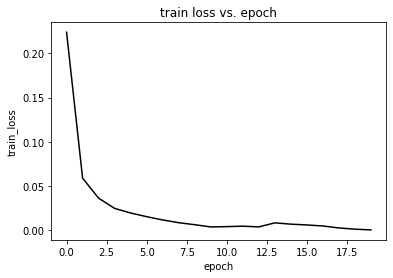

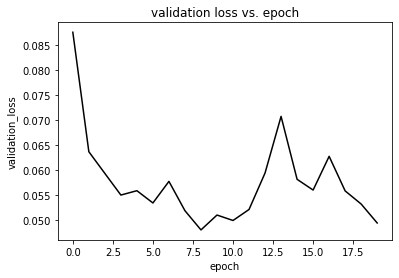

In [6]:
classifier = Classifier()
classifier.train()

In [7]:


def visualize_results(gan):
      sample_z_ = torch.rand((10, gan.z_dim)).cuda()
      samples = gan.G(sample_z_)
      samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)
      samples = (samples + 1) / 2
      plt.figure(figsize=((1,10)))
      fig,ax = plt.subplots(1,10)
      for i in range(10):
          s=ax[i].imshow(np.squeeze(samples[i,]))
          s=ax[i].get_xaxis().set_visible(False)
          s=ax[i].get_yaxis().set_visible(False)
      s=plt.show()

In [8]:
def initialize_weights(net):
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()

In [21]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder,self).__init__()
        c =64
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
        self.fc = nn.Linear(in_features=c*2*7*7, out_features=10)
        self.bn1 = nn.BatchNorm2d(c)
        self.bn2 = nn.BatchNorm2d(c*2)
        initialize_weights(self)   
            
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = F.relu(self.conv2(x))
        x = self.bn2(x)
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x = self.fc(x)
        return x

In [10]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim, input_size=28, base_size=64):
        super(Generator, self).__init__()  
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = 28
        self.base_size = base_size

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 2*self.base_size * (self.input_size // 4) * (self.input_size // 4)),
            nn.BatchNorm1d(2*self.base_size * (self.input_size // 4) * (self.input_size // 4)),
            nn.ReLU(),
        )

        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(2*self.base_size, self.base_size, 4, 2, 1),
            nn.BatchNorm2d(self.base_size),
            nn.ReLU(),
            nn.ConvTranspose2d(self.base_size, self.output_dim, 4, 2, 1),
            nn.Tanh(),
        )

        initialize_weights(self)           
    
    # forward method
    def forward(self, x): 
       # x = x.view(-1, self.input_size * self.input_size)
        x = self.fc(x)
        x = x.view(-1, 2*self.base_size, (self.input_size // 4), (self.input_size // 4))
        x = self.deconv(x)
        return x




class Discriminator(nn.Module):
  def __init__(self, input_dim, output_dim, input_size=28, base_size=64):
        super(Discriminator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size
        self.base_size = base_size



 
        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, self.base_size, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(self.base_size, 2*self.base_size, 4, 2, 1),
            nn.BatchNorm2d(2*self.base_size),
            nn.LeakyReLU(0.2),
        )
        self.fc = nn.Sequential(
            nn.Linear(2*self.base_size * (self.input_size // 4) * (self.input_size // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.output_dim),
            
        )
        self.Sig = nn.Sigmoid()

        initialize_weights(self)

     # forward method
  def forward(self, x):
        x = self.conv(x)
        y = x.view(-1, 2*self.base_size * (self.input_size // 4) * (self.input_size // 4))
        logits  = self.fc(y) # logits 
        prob = self.Sig(logits) ## prob

        return prob,logits,x

In [11]:

# Sigmoid loss with logits, keep as tensor 
# z = labels , torch.ones_like discriminator sigmoid prob
# x =  discriminator logits prob 

def Sigmoid_logits_loss( logits,labels):
  z = labels
  x = logits 
  #z = z * -torch.log(torch.sigmoid(x)) + (1 - z) * -torch.log(1 - torch.sigmoid(x))
  #z = z * -torch.log(1 / (1 + torch.exp(-x))) + (1 - z) * -torch.log(torch.exp(-x) / (1 + torch.exp(-x)))
  #z = z * torch.log(1 + torch.exp(-x)) + (1 - z) * (-torch.log(torch.exp(-x)) + torch.log(1 + torch.exp(-x)))
  #z = z * torch.log(1 + torch.exp(-x)) + (1 - z) * (x + torch.log(1 + torch.exp(-x)))
  loss = 0
  for i, x in enumerate(x):
    for j, z in enumerate(z):
      if x >0:
        loss = x - x * z + torch.log(1 + torch.exp(-x))
      else:
        loss = - x * z + torch.log(1 + torch.exp(x))
      loss += loss
    return loss


In [28]:
def inception_score(gan, n_split=10, eps=1E-16):

      num_images = 100
      sample_z_ = torch.rand((num_images, gan.z_dim)).cuda()
      #print(sample_z_.shape)
      samples = gan.G(sample_z_)
      #print(samples.shape)

      samples_np = samples.cpu().data.numpy()

      # enumerate splits of images/predictions
      scores = list()
      n_part = floor(num_images / n_split)

      for i in range(n_part):
          # retrieve subset of images
          ix_start, ix_end = i * n_part, (i+1) * n_part
          subset = samples_np[ix_start:ix_end]
          # convert from uint8 to float32
          subset = subset.astype('float32')
          # predict p(y|x)
          outputs = classifier.net(torch.from_numpy(subset).cuda())
          outputs = F.softmax(outputs,dim=1)
          #print("outputs: ", outputs.shape)
          #print("\t", outputs)
          
          #y, p_yx = torch.max(outputs.data, 1)
          #print("p_yx: ", p_yx.shape)
          #print("\t", p_yx)
          #print(y.shape)
          p_yx_d = gan.D(torch.from_numpy(subset).cuda())
         # print("\tD: ", p_yx_d.shape)
          #print(p_yx.shape)
          #print(p_yx)
          p_yx = outputs.cpu().data.numpy()
         # print("p_yx numpy", p_yx)
          p_yx = np.expand_dims(p_yx, 0)
          #print(p_yx.shape)
         # print("p_yx expanded", p_yx)
          # calculate p(y)
          p_y = np.expand_dims(p_yx.mean(axis=1), 0)
          #print("p_y", p_y)
          # calculate KL divergence using log probabilities
          kl_d = p_yx * (np.log(p_yx + eps) - np.log(p_y + eps))
         # print("kl_d", kl_d)
          # sum over classes
          sum_kl_d = kl_d.sum(axis=1)
          #print("sum_kl_d", sum_kl_d)
          # average over images
          avg_kl_d = np.mean(sum_kl_d)
          #print("avg_kl_d", avg_kl_d)
          # undo the log
          is_score = np.exp(avg_kl_d)
          print("is_score", is_score)
          print('\n\n')
		      # store
          scores.append(is_score)
        
      # average across images
      is_avg, is_std = np.mean(scores), np.std(scores)
      return is_avg,is_std
     
      #print(is_avg, is_std)

# Creating GAN Network

In [34]:

from torch.autograd import grad as torch_grad
class GAN():
    def __init__(self,params):
        # parameters
        self.epoch = params['max_epochs']
        self.sample_num = 100
        self.batch_size = 300
        self.input_size = 28
        self.z_dim = params['z_dim']
        self.base_size = params['base_size']

     
        self.lamda_p = 1.0     # regularization term of gradient penalty
        self.lamda_r = 1.0    # autoencoders regularization term  
       
        
        
        # load dataset
        self.data_loader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=self.batch_size, 
                                               shuffle=True)
        data = self.data_loader.__iter__().__next__()[0]

        print(data.shape[1])

        # initialization of the generator and discriminator and autoencoder 
        self.A = autoencoder().cuda()
        self.G = Generator(input_dim=self.z_dim, output_dim=data.shape[1], input_size=self.input_size,base_size=self.base_size).cuda()
        self.D = Discriminator(input_dim=data.shape[1], output_dim=1, input_size=self.input_size,base_size=self.base_size).cuda()
      

        self.A_optimizer =  optim.Adam(self.A.parameters(), lr=params['lr_g'], betas=(params['beta1'], params['beta2']),eps=1e-09)
        self.G_optimizer = optim.Adam(self.G.parameters(), lr=params['lr_g'], betas=(params['beta1'], params['beta2']),eps=1e-09)
        self.D_optimizer = optim.Adam(self.D.parameters(), lr=params['lr_d'], betas=(params['beta1'], params['beta2']),eps=1e-09)
        
      
    
        
# Fucntion to train the GAN, where you alternate between the training of the genenator and discriminator
#--------------------------------------------------------------------------------------------------------

    def train(self):
        self.train_hist = {}
        self.train_hist['D_loss'] = []
        self.train_hist['G_loss'] = []
        self.train_hist['IS_score'] = []

        # Setting up the labels for real and fake images
        self.y_real_, self.y_fake_ = torch.ones(self.batch_size,1).fill_(0.9).type(torch.float32).cuda(), torch.zeros(self.batch_size, 1).cuda()
        
        print('training start!!')

        for epoch in range(self.epoch):
            epoch_start_time = time.time()


            for iter, (x_, _) in enumerate(self.data_loader):
                if iter == self.data_loader.dataset.__len__() // self.batch_size:
                    break
                z_ = torch.rand((self.batch_size, self.z_dim))
               
                x_, z_ = x_.cuda() ,z_.cuda()
        
        

                #-------------Train Autoencoder & Generator to minimize reconstruction loss ------------# 
                # auto-encoders and its regularizatize 
                # zero the gradients 

                self.D_optimizer.zero_grad() 
                self.A_optimizer.zero_grad()
                # reconstructed image
                recon = self.A(x_)
                
                self.G_optimizer.zero_grad()
                X_r = self.G(recon) # reconstructed iamges from generator 
               # print("\tX_r:", X_r.shape)
                X_f = self.G(z_) # fake images from generator 
                #print("\tX_f:", X_f.shape)
                X_r, X_f = X_r, X_f
                
                
                D_real_prob, D_real_logits, D_real = self.D(x_)
                D_recon_prob, D_recon_logits,D_recon= self.D(X_r)
                D_fake_prob, D_fake_logits,D_fake = self.D(X_f)

                #print(D_real.shape)
                #print(x_.shape)

                ##auto-encoders and Regularization from Dist-Gan paper 

                R_loss = torch.mean(torch.square(D_real-D_recon))
                #print("\tR_loss:", R_loss.shape)
                f = torch.mean(D_recon - D_fake) #distance between reconstructed imgs and reconstructed fake imgs 
                #print("\tf:", f.shape)
                # w parmeter = sqrt(latent dim * 1/ feature dim ) = .1562 for 100
                # latent dim 1 wp = .01562
                # latent dim 10 wp = .04939

                wp = torch.sqrt(self.z_dim/4096)
                g = torch.mean(recon - z_) * wp # distance between reconstruced imgs and noise # higher value = initial lowvD training loss  
                #print("\tg:", g.shape)
                R_reg = torch.square(f - g)

               
                # Train Autoencoder with R_loss 
                R_loss = R_loss + self.lamda_r * R_reg
                #print("\tR_loss", R_loss.shape)
                R_loss.backward()
                self.A_optimizer.step()
                
                D_real_prob, D_real_logits, d_real = self.D(x_.detach())
                D_recon_prob, D_recon_logits,D_recon= self.D(X_r.detach())
                D_fake_prob, D_fake_logits,D_fake = self.D(X_f.detach())


                #Train Generator with G_Loss 
               
                G_loss = torch.abs(torch.mean(D_real_prob)- torch.mean(D_fake_prob))
                G_loss.backward()
                self.G_optimizer.step()



               #-----------Train Discriminator --------#######
                
                #Train Discriminator with Discriminator Score 
                D_real_prob, D_real_logits, d_real = self.D(x_.detach())
                D_recon_prob, D_recon_logits,D_recon= self.D(X_r.detach())
                D_fake_prob, D_fake_logits,D_fake = self.D(X_f.detach())
                


                # interpolation     
                epsilon = torch.rand(x_.size())
                epsilon = epsilon.cuda()
                interpolation = x_ * epsilon + (1-epsilon) * X_f
                d_inter_prob, d_inter_logits, d_inter = self.D(interpolation)

                # Gradien Penalty 
                gradients = torch_grad(d_inter_logits, interpolation, grad_outputs=torch.ones(d_inter_logits.size()).cuda())[0]
              
                slopes = torch.sqrt(torch.mean(torch.square(gradients),1))
                gp = torch.mean((slopes-1)**2)
            
                #print(D_real_logits.shape)
            
                # Discriminator loss on data
                d_loss_real = torch.mean(Sigmoid_logits_loss( D_real_logits,torch.ones_like(D_real_prob)))
                d_loss_recon = torch.mean(Sigmoid_logits_loss(D_recon_logits, torch.ones_like(D_recon_prob)))
                d_loss_fake = torch.mean(Sigmoid_logits_loss(D_fake_logits,torch.zeros_like(D_fake_prob)))
               # print(d_loss_real.shape)

                # loss w.r.t gradient penalty and reconstruction term 
                D_loss = d_loss_real + d_loss_recon + d_loss_fake
                D_loss = D_loss + self.lamda_p * gp

          
              
                #train Discriminator
                
                D_loss.backward()
                self.D_optimizer.step()



                # 5. Set the current loss in self.train_hist['D_loss]
                self.train_hist['D_loss'].append(D_loss.item())
                
      
     
                #---------------Train Generator to minimize discriminator score --------#
                D_real_prob, D_real_logits, d_real = self.D(x_.detach())
                D_recon_prob, D_recon_logits,D_recon= self.D(X_r.detach())
                D_fake_prob, D_fake_logits,D_fake = self.D(X_f.detach())
             
                #self.G_optimizer.zero_grad()
                G_loss = torch.abs(torch.mean(D_real_prob) - torch.mean(D_fake_prob))
                G_loss.backward()
                self.G_optimizer.step()
                # 5. Set the current loss in self.train_hist['G_loss]    
                self.train_hist['G_loss'].append(G_loss.item())

                # Print iterations and losses

                if ((iter + 1) % 50) == 0:
              
                  print("Epoch: [%2d] [%4d/%4d] D_loss: %.8f, G_loss: %.8f" %
                          ((epoch + 1), (iter + 1), self.data_loader.dataset.__len__() // self.batch_size, D_loss.item(), G_loss.item()))
          
                     # Visualize results
            if ((epoch + 1) % 10) == 1:
                with torch.no_grad():
                  print("Training at Epoch:")
                  print(epoch)
                  visualise_output(self)
                  is_avg, _ = inception_score(self)
                  self.train_hist['IS_score'].append(is_avg)
           
          
            
           

              
           
            


        print("Training finished!")

In [14]:
import matplotlib.pyplot as plt
plt.ion()
import torchvision.utils

def visualise_output(gan):

    with torch.no_grad():
        sample_z_ = torch.rand((gan.base_size, gan.z_dim)).cuda()
        samples = gan.G(sample_z_)
        samples = samples.cpu()
        samples = (samples + 1) / 2
        np_imagegrid = torchvision.utils.make_grid(samples[1:100], 10, 5).detach().numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()


1
training start!!
Epoch: [ 1] [  50/ 200] D_loss: 3.04830623, G_loss: 0.00827503
Epoch: [ 1] [ 100/ 200] D_loss: 3.42795181, G_loss: 0.00073266
Epoch: [ 1] [ 150/ 200] D_loss: 7.65949678, G_loss: 0.00324881
Epoch: [ 1] [ 200/ 200] D_loss: 4.56088305, G_loss: 0.00370532
Training at Epoch:
0


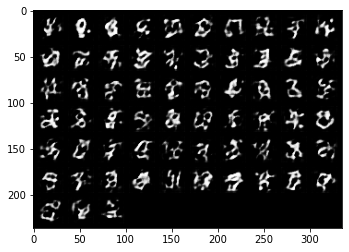

avg_kl_d 2.1777716
is_score 8.826614



avg_kl_d 1.8893137
is_score 6.614827



avg_kl_d 1.9211397
is_score 6.828737



avg_kl_d 1.8295807
is_score 6.2312727



avg_kl_d 2.1115758
is_score 8.26125



avg_kl_d 2.0607076
is_score 7.8515234



avg_kl_d 2.1003141
is_score 8.1687355



avg_kl_d 1.9341367
is_score 6.91807



avg_kl_d 1.8738645
is_score 6.513419



avg_kl_d 1.9877545
is_score 7.299125



Epoch: [ 2] [  50/ 200] D_loss: 4.85109425, G_loss: 0.00124723
Epoch: [ 2] [ 100/ 200] D_loss: 7.10625935, G_loss: 0.00408739
Epoch: [ 2] [ 150/ 200] D_loss: 8.33856583, G_loss: 0.01585042
Epoch: [ 2] [ 200/ 200] D_loss: 5.50717306, G_loss: 0.01071602
Training at Epoch:
1


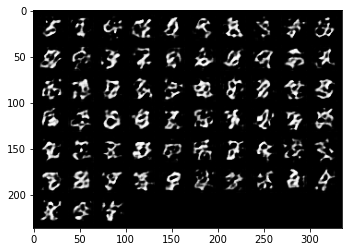

avg_kl_d 2.03192
is_score 7.628719



avg_kl_d 1.9318058
is_score 6.901963



avg_kl_d 1.9243473
is_score 6.8506756



avg_kl_d 1.9023691
is_score 6.701753



avg_kl_d 2.0314689
is_score 7.6252785



avg_kl_d 2.0814462
is_score 8.016053



avg_kl_d 1.7543001
is_score 5.779401



avg_kl_d 2.027624
is_score 7.5960155



avg_kl_d 2.1057315
is_score 8.213109



avg_kl_d 2.0653195
is_score 7.887818



Epoch: [ 3] [  50/ 200] D_loss: 6.10796356, G_loss: 0.00038242
Epoch: [ 3] [ 100/ 200] D_loss: 9.53407574, G_loss: 0.00392520
Epoch: [ 3] [ 150/ 200] D_loss: 2.94941282, G_loss: 0.00800991
Epoch: [ 3] [ 200/ 200] D_loss: 3.05454731, G_loss: 0.00279343
Training at Epoch:
2


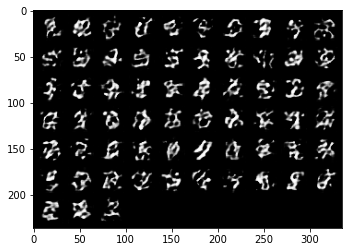

avg_kl_d 2.1157813
is_score 8.296065



avg_kl_d 1.9243685
is_score 6.850821



avg_kl_d 1.8562601
is_score 6.3997574



avg_kl_d 2.0299654
is_score 7.613823



avg_kl_d 2.182774
is_score 8.870881



avg_kl_d 1.991985
is_score 7.3300695



avg_kl_d 2.0149803
is_score 7.50058



avg_kl_d 1.9459337
is_score 7.000165



avg_kl_d 2.0518744
is_score 7.782475



avg_kl_d 1.9736888
is_score 7.1971774



Epoch: [ 4] [  50/ 200] D_loss: 5.07647657, G_loss: 0.00192475
Epoch: [ 4] [ 100/ 200] D_loss: 5.23299122, G_loss: 0.00221008
Epoch: [ 4] [ 150/ 200] D_loss: 3.59304237, G_loss: 0.00527233
Epoch: [ 4] [ 200/ 200] D_loss: 3.78862119, G_loss: 0.00137937
Training at Epoch:
3


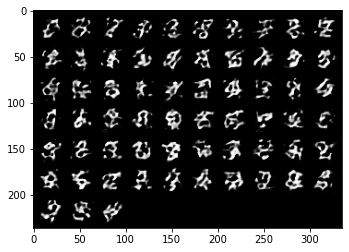

avg_kl_d 2.0714974
is_score 7.936699



avg_kl_d 2.0058696
is_score 7.4325547



avg_kl_d 2.1420145
is_score 8.516577



avg_kl_d 2.0220704
is_score 7.5539484



avg_kl_d 1.930273
is_score 6.8913913



avg_kl_d 2.0659983
is_score 7.893174



avg_kl_d 1.9906536
is_score 7.3203173



avg_kl_d 1.9047358
is_score 6.7176323



avg_kl_d 1.931374
is_score 6.898982



avg_kl_d 2.1723926
is_score 8.779264



Epoch: [ 5] [  50/ 200] D_loss: 4.42303705, G_loss: 0.00239348
Epoch: [ 5] [ 100/ 200] D_loss: 8.91331577, G_loss: 0.00788832
Epoch: [ 5] [ 150/ 200] D_loss: 3.04576659, G_loss: 0.00452703
Epoch: [ 5] [ 200/ 200] D_loss: 4.62324429, G_loss: 0.00734502
Training at Epoch:
4


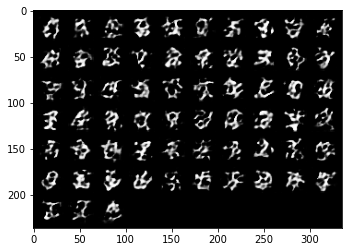

avg_kl_d 2.2377448
is_score 9.372171



avg_kl_d 1.9004681
is_score 6.689025



avg_kl_d 1.9379733
is_score 6.9446616



avg_kl_d 2.0225334
is_score 7.557447



avg_kl_d 2.0660965
is_score 7.893949



avg_kl_d 1.8624907
is_score 6.4397564



avg_kl_d 2.0748415
is_score 7.963284



avg_kl_d 1.8876206
is_score 6.6036367



avg_kl_d 1.4547604
is_score 4.2834573



avg_kl_d 1.9890392
is_score 7.3085084



Epoch: [ 6] [  50/ 200] D_loss: 5.12130594, G_loss: 0.00308102
Epoch: [ 6] [ 100/ 200] D_loss: 3.81144142, G_loss: 0.01834792
Epoch: [ 6] [ 150/ 200] D_loss: 4.96580887, G_loss: 0.01636994
Epoch: [ 6] [ 200/ 200] D_loss: 5.27762413, G_loss: 0.00329453
Training at Epoch:
5


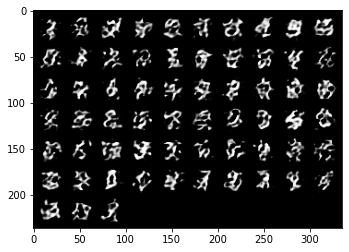

avg_kl_d 2.086512
is_score 8.056766



avg_kl_d 2.0646427
is_score 7.88248



avg_kl_d 1.9992545
is_score 7.3835497



avg_kl_d 2.0869417
is_score 8.060226



avg_kl_d 2.0237918
is_score 7.5669627



avg_kl_d 1.9354687
is_score 6.9272895



avg_kl_d 2.1827035
is_score 8.8702545



avg_kl_d 2.1507263
is_score 8.591096



avg_kl_d 2.0882213
is_score 8.070547



avg_kl_d 2.0581248
is_score 7.8312707



Epoch: [ 7] [  50/ 200] D_loss: 3.37232208, G_loss: 0.00380117
Epoch: [ 7] [ 100/ 200] D_loss: 3.20885062, G_loss: 0.00588596
Epoch: [ 7] [ 150/ 200] D_loss: 5.80451727, G_loss: 0.00546134
Epoch: [ 7] [ 200/ 200] D_loss: 4.28121853, G_loss: 0.00223589
Training at Epoch:
6


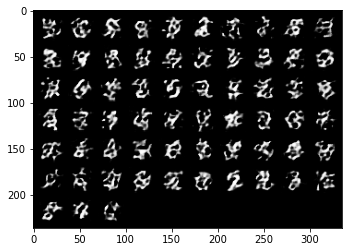

avg_kl_d 1.8392204
is_score 6.291631



avg_kl_d 1.9821482
is_score 7.2583184



avg_kl_d 1.7185482
is_score 5.576427



avg_kl_d 1.9639629
is_score 7.127517



avg_kl_d 2.0817761
is_score 8.018699



avg_kl_d 2.048586
is_score 7.756924



avg_kl_d 2.1303508
is_score 8.417819



avg_kl_d 2.2267082
is_score 9.269302



avg_kl_d 2.0778089
is_score 7.9869494



avg_kl_d 2.0558012
is_score 7.8130956



Epoch: [ 8] [  50/ 200] D_loss: 4.54871225, G_loss: 0.00622988
Epoch: [ 8] [ 100/ 200] D_loss: 4.93463659, G_loss: 0.00683075
Epoch: [ 8] [ 150/ 200] D_loss: 4.21318150, G_loss: 0.00280780
Epoch: [ 8] [ 200/ 200] D_loss: 5.08837986, G_loss: 0.00618815
Training at Epoch:
7


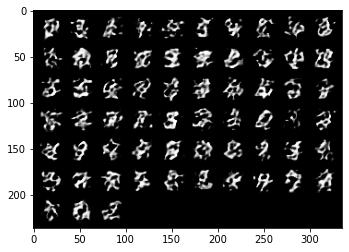

avg_kl_d 1.981776
is_score 7.2556176



avg_kl_d 1.9440578
is_score 6.987046



avg_kl_d 1.9367883
is_score 6.9364376



avg_kl_d 2.0067725
is_score 7.439269



avg_kl_d 1.8225037
is_score 6.18733



avg_kl_d 2.1875217
is_score 8.913096



avg_kl_d 1.8384863
is_score 6.2870145



avg_kl_d 2.0059237
is_score 7.432957



avg_kl_d 2.035046
is_score 7.652605



avg_kl_d 2.015164
is_score 7.501957



Epoch: [ 9] [  50/ 200] D_loss: 4.56509352, G_loss: 0.00397211
Epoch: [ 9] [ 100/ 200] D_loss: 4.93572330, G_loss: 0.00695240
Epoch: [ 9] [ 150/ 200] D_loss: 5.70629358, G_loss: 0.01150751
Epoch: [ 9] [ 200/ 200] D_loss: 3.82936978, G_loss: 0.00795060
Training at Epoch:
8


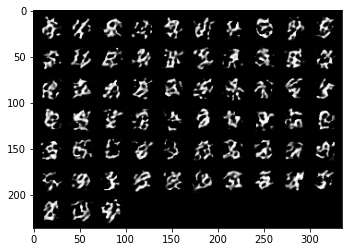

avg_kl_d 1.8876234
is_score 6.603656



avg_kl_d 1.9399805
is_score 6.958615



avg_kl_d 1.9464598
is_score 7.0038486



avg_kl_d 1.8525937
is_score 6.3763356



avg_kl_d 1.8562797
is_score 6.399883



avg_kl_d 2.2194
is_score 9.201807



avg_kl_d 2.0262825
is_score 7.585834



avg_kl_d 2.1261597
is_score 8.382613



avg_kl_d 2.0751307
is_score 7.9655876



avg_kl_d 2.0903628
is_score 8.087849



Epoch: [10] [  50/ 200] D_loss: 5.22526073, G_loss: 0.00485563
Epoch: [10] [ 100/ 200] D_loss: 3.95572090, G_loss: 0.00894278
Epoch: [10] [ 150/ 200] D_loss: 2.30594182, G_loss: 0.01365274
Epoch: [10] [ 200/ 200] D_loss: 7.34335899, G_loss: 0.01361400
Training at Epoch:
9


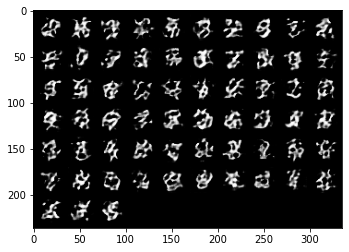

avg_kl_d 2.014424
is_score 7.4964094



avg_kl_d 1.95532
is_score 7.0661798



avg_kl_d 1.9633636
is_score 7.1232467



avg_kl_d 2.1138096
is_score 8.279723



avg_kl_d 2.1007686
is_score 8.172449



avg_kl_d 1.9835501
is_score 7.268501



avg_kl_d 2.008197
is_score 7.4498734



avg_kl_d 1.8553501
is_score 6.3939366



avg_kl_d 1.9243851
is_score 6.8509345



avg_kl_d 2.1882334
is_score 8.919442



Epoch: [11] [  50/ 200] D_loss: 4.52586889, G_loss: 0.01232922
Epoch: [11] [ 100/ 200] D_loss: 5.36370564, G_loss: 0.01250714
Epoch: [11] [ 150/ 200] D_loss: 2.84940672, G_loss: 0.00543231
Epoch: [11] [ 200/ 200] D_loss: 3.92444515, G_loss: 0.01164860
Training at Epoch:
10


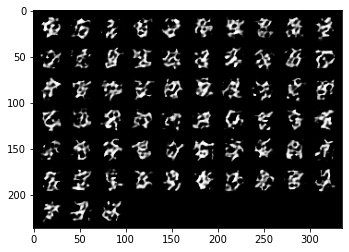

avg_kl_d 1.9648044
is_score 7.1335173



avg_kl_d 1.8128494
is_score 6.1278834



avg_kl_d 1.9307878
is_score 6.89494



avg_kl_d 1.7760137
is_score 5.9062653



avg_kl_d 2.0720918
is_score 7.941418



avg_kl_d 1.6910414
is_score 5.425127



avg_kl_d 1.8192062
is_score 6.166961



avg_kl_d 1.8817523
is_score 6.564998



avg_kl_d 1.8731143
is_score 6.5085344



avg_kl_d 1.8124329
is_score 6.1253314



Epoch: [12] [  50/ 200] D_loss: 3.68533754, G_loss: 0.00060517
Epoch: [12] [ 100/ 200] D_loss: 5.60146141, G_loss: 0.01267028
Epoch: [12] [ 150/ 200] D_loss: 6.07519865, G_loss: 0.00653034
Epoch: [12] [ 200/ 200] D_loss: 5.09606743, G_loss: 0.00039905
Training at Epoch:
11


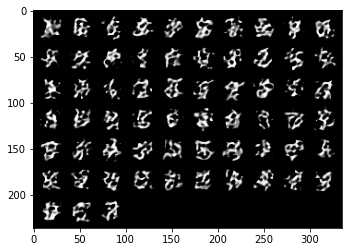

avg_kl_d 2.0333667
is_score 7.6397634



avg_kl_d 1.9495485
is_score 7.025515



avg_kl_d 1.8871889
is_score 6.6007867



avg_kl_d 2.2263703
is_score 9.266172



avg_kl_d 1.7910057
is_score 5.995479



avg_kl_d 2.0680375
is_score 7.9092855



avg_kl_d 2.1403463
is_score 8.502381



avg_kl_d 1.8930852
is_score 6.639823



avg_kl_d 2.010854
is_score 7.469693



avg_kl_d 2.0987887
is_score 8.156284



Epoch: [13] [  50/ 200] D_loss: 6.66201162, G_loss: 0.00802064
Epoch: [13] [ 100/ 200] D_loss: 5.31474304, G_loss: 0.01062626
Epoch: [13] [ 150/ 200] D_loss: 6.93008995, G_loss: 0.01765889
Epoch: [13] [ 200/ 200] D_loss: 3.56529760, G_loss: 0.01221108
Training at Epoch:
12


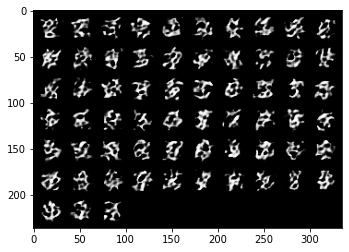

avg_kl_d 1.9627014
is_score 7.118531



avg_kl_d 2.1571689
is_score 8.646624



avg_kl_d 2.032304
is_score 7.6316504



avg_kl_d 2.061694
is_score 7.8592715



avg_kl_d 1.8806155
is_score 6.5575395



avg_kl_d 1.9748781
is_score 7.2057414



avg_kl_d 2.0369318
is_score 7.667049



avg_kl_d 2.0246391
is_score 7.573377



avg_kl_d 1.8369535
is_score 6.2773848



avg_kl_d 1.8840549
is_score 6.580133



Epoch: [14] [  50/ 200] D_loss: 3.54628658, G_loss: 0.00921160
Epoch: [14] [ 100/ 200] D_loss: 8.76306725, G_loss: 0.01936376
Epoch: [14] [ 150/ 200] D_loss: 5.14262104, G_loss: 0.00771159
Epoch: [14] [ 200/ 200] D_loss: 5.94902277, G_loss: 0.01291955
Training at Epoch:
13


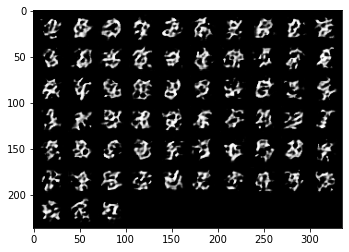

avg_kl_d 1.8199053
is_score 6.1712737



avg_kl_d 1.8251759
is_score 6.203886



avg_kl_d 1.8463757
is_score 6.336811



avg_kl_d 1.752682
is_score 5.7700567



avg_kl_d 2.0803208
is_score 8.007037



avg_kl_d 2.2569146
is_score 9.553568



avg_kl_d 1.8726139
is_score 6.5052786



avg_kl_d 1.9816284
is_score 7.2545466



avg_kl_d 2.06385
is_score 7.876234



avg_kl_d 2.1522746
is_score 8.604408



Epoch: [15] [  50/ 200] D_loss: 4.87361097, G_loss: 0.01627773
Epoch: [15] [ 100/ 200] D_loss: 5.72478008, G_loss: 0.01812327
Epoch: [15] [ 150/ 200] D_loss: 4.39402866, G_loss: 0.01763940
Epoch: [15] [ 200/ 200] D_loss: 5.39798117, G_loss: 0.02608144
Training at Epoch:
14


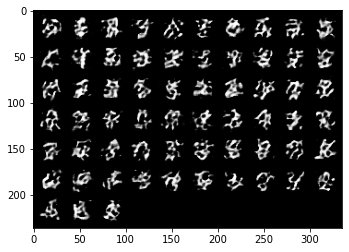

avg_kl_d 1.7112913
is_score 5.5361056



avg_kl_d 1.8387117
is_score 6.2884316



avg_kl_d 1.9303929
is_score 6.892217



avg_kl_d 1.8895311
is_score 6.6162653



avg_kl_d 1.8892205
is_score 6.6142106



avg_kl_d 2.2136512
is_score 9.149061



avg_kl_d 2.1660333
is_score 8.723611



avg_kl_d 2.0072348
is_score 7.442708



avg_kl_d 1.881732
is_score 6.5648646



avg_kl_d 1.9458466
is_score 6.999555



Epoch: [16] [  50/ 200] D_loss: 4.40373087, G_loss: 0.01856941
Epoch: [16] [ 100/ 200] D_loss: 2.70360303, G_loss: 0.01538640
Epoch: [16] [ 150/ 200] D_loss: 4.92600346, G_loss: 0.01182544
Epoch: [16] [ 200/ 200] D_loss: 5.08140182, G_loss: 0.02512676
Training at Epoch:
15


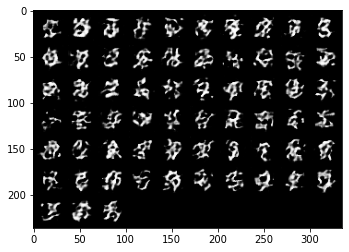

avg_kl_d 1.7564074
is_score 5.791593



avg_kl_d 1.8823782
is_score 6.569109



avg_kl_d 1.9658306
is_score 7.1408415



avg_kl_d 2.0030699
is_score 7.411774



avg_kl_d 1.983867
is_score 7.270805



avg_kl_d 2.0482612
is_score 7.7544055



avg_kl_d 1.9721987
is_score 7.18646



avg_kl_d 1.9791148
is_score 7.2363343



avg_kl_d 1.9812839
is_score 7.2520475



avg_kl_d 2.0089233
is_score 7.4552855



Epoch: [17] [  50/ 200] D_loss: 5.36809826, G_loss: 0.02644908
Epoch: [17] [ 100/ 200] D_loss: 4.15169621, G_loss: 0.03099239
Epoch: [17] [ 150/ 200] D_loss: 4.68484926, G_loss: 0.02409661
Epoch: [17] [ 200/ 200] D_loss: 6.42952538, G_loss: 0.03729057
Training at Epoch:
16


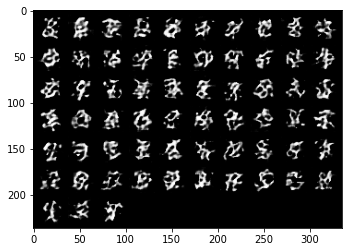

avg_kl_d 1.9742317
is_score 7.201085



avg_kl_d 1.9259617
is_score 6.8617444



avg_kl_d 1.9172871
is_score 6.8024793



avg_kl_d 1.9059044
is_score 6.725487



avg_kl_d 2.0128436
is_score 7.48457



avg_kl_d 2.027485
is_score 7.59496



avg_kl_d 2.1285641
is_score 8.402793



avg_kl_d 2.1320648
is_score 8.4322605



avg_kl_d 2.04967
is_score 7.765338



avg_kl_d 1.9769878
is_score 7.220959



Epoch: [18] [  50/ 200] D_loss: 4.83838129, G_loss: 0.03318709
Epoch: [18] [ 100/ 200] D_loss: 7.23636484, G_loss: 0.02675277
Epoch: [18] [ 150/ 200] D_loss: 2.79322314, G_loss: 0.03135651
Epoch: [18] [ 200/ 200] D_loss: 7.81552172, G_loss: 0.02961349
Training at Epoch:
17


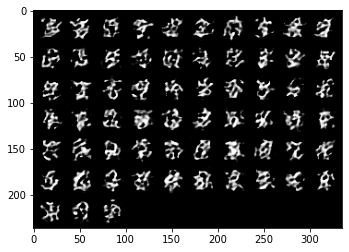

avg_kl_d 2.1109939
is_score 8.256443



avg_kl_d 1.8797357
is_score 6.5517726



avg_kl_d 2.0152912
is_score 7.5029125



avg_kl_d 1.820124
is_score 6.1726236



avg_kl_d 1.9466722
is_score 7.0053363



avg_kl_d 2.1311643
is_score 8.42467



avg_kl_d 1.8442075
is_score 6.323087



avg_kl_d 2.080756
is_score 8.010522



avg_kl_d 2.0674796
is_score 7.9048743



avg_kl_d 2.1282115
is_score 8.39983



Epoch: [19] [  50/ 200] D_loss: 4.24356365, G_loss: 0.03268778
Epoch: [19] [ 100/ 200] D_loss: 9.23507404, G_loss: 0.04498297
Epoch: [19] [ 150/ 200] D_loss: 4.34908724, G_loss: 0.03773177
Epoch: [19] [ 200/ 200] D_loss: 3.63043952, G_loss: 0.03291708
Training at Epoch:
18


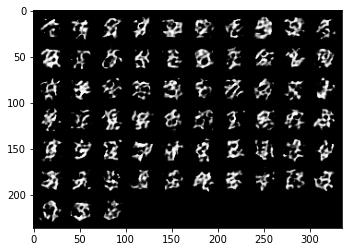

avg_kl_d 1.9383875
is_score 6.947539



avg_kl_d 2.0487278
is_score 7.758025



avg_kl_d 1.908495
is_score 6.742933



avg_kl_d 2.0745757
is_score 7.961168



avg_kl_d 1.8817583
is_score 6.565038



avg_kl_d 1.9673913
is_score 7.1519947



avg_kl_d 2.1543067
is_score 8.621909



avg_kl_d 1.9835466
is_score 7.268476



avg_kl_d 1.8576237
is_score 6.40849



avg_kl_d 1.8512337
is_score 6.3676705



Epoch: [20] [  50/ 200] D_loss: 3.05116701, G_loss: 0.04524046
Epoch: [20] [ 100/ 200] D_loss: 4.56627131, G_loss: 0.05370611
Epoch: [20] [ 150/ 200] D_loss: 3.27928257, G_loss: 0.06018925
Epoch: [20] [ 200/ 200] D_loss: 4.56071711, G_loss: 0.05453390
Training at Epoch:
19


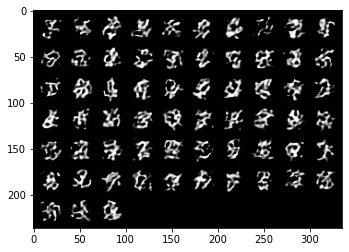

avg_kl_d 1.9211166
is_score 6.8285785



avg_kl_d 1.987681
is_score 7.2985888



avg_kl_d 1.9938421
is_score 7.3436956



avg_kl_d 2.008432
is_score 7.451623



avg_kl_d 1.9055977
is_score 6.7234244



avg_kl_d 1.8382797
is_score 6.285716



avg_kl_d 2.1269248
is_score 8.389029



avg_kl_d 2.2629282
is_score 9.611192



avg_kl_d 1.9584379
is_score 7.088246



avg_kl_d 1.8259885
is_score 6.2089295



Epoch: [21] [  50/ 200] D_loss: 5.58854151, G_loss: 0.05010784
Epoch: [21] [ 100/ 200] D_loss: 3.36038780, G_loss: 0.05072838
Epoch: [21] [ 150/ 200] D_loss: 4.31804180, G_loss: 0.04308498
Epoch: [21] [ 200/ 200] D_loss: 2.20409846, G_loss: 0.04979026
Training at Epoch:
20


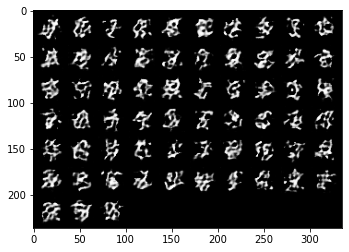

avg_kl_d 1.9580778
is_score 7.085694



avg_kl_d 2.1364112
is_score 8.468988



avg_kl_d 1.8724709
is_score 6.504348



avg_kl_d 2.0225773
is_score 7.557779



avg_kl_d 2.0261128
is_score 7.5845456



avg_kl_d 1.9470743
is_score 7.0081534



avg_kl_d 2.0457852
is_score 7.7352295



avg_kl_d 1.8720181
is_score 6.5014033



avg_kl_d 2.0478008
is_score 7.7508364



avg_kl_d 2.0564678
is_score 7.8183055



Epoch: [22] [  50/ 200] D_loss: 2.97627211, G_loss: 0.05674821
Epoch: [22] [ 100/ 200] D_loss: 5.95628452, G_loss: 0.05301279
Epoch: [22] [ 150/ 200] D_loss: 5.16954613, G_loss: 0.06516123
Epoch: [22] [ 200/ 200] D_loss: 6.40440893, G_loss: 0.06049234
Training at Epoch:
21


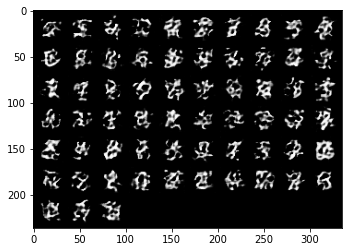

avg_kl_d 2.014877
is_score 7.4998055



avg_kl_d 2.0466502
is_score 7.741924



avg_kl_d 1.8840504
is_score 6.580103



avg_kl_d 1.8916051
is_score 6.6300025



avg_kl_d 2.0260415
is_score 7.5840054



avg_kl_d 1.5272092
is_score 4.605306



avg_kl_d 2.2133908
is_score 9.146678



avg_kl_d 2.0987003
is_score 8.155563



avg_kl_d 1.9052356
is_score 6.720991



avg_kl_d 1.7936395
is_score 6.0112906



Epoch: [23] [  50/ 200] D_loss: 8.25924587, G_loss: 0.05820996
Epoch: [23] [ 100/ 200] D_loss: 5.14184618, G_loss: 0.05957949
Epoch: [23] [ 150/ 200] D_loss: 7.92602634, G_loss: 0.04923254
Epoch: [23] [ 200/ 200] D_loss: 3.81203270, G_loss: 0.06719756
Training at Epoch:
22


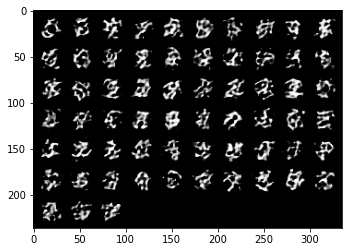

avg_kl_d 1.7231805
is_score 5.602319



avg_kl_d 1.9056838
is_score 6.724004



avg_kl_d 1.9412267
is_score 6.967293



avg_kl_d 2.1720452
is_score 8.776215



avg_kl_d 1.9639187
is_score 7.1272016



avg_kl_d 1.9848301
is_score 7.277811



avg_kl_d 1.9964008
is_score 7.3625097



avg_kl_d 1.9924091
is_score 7.3331785



avg_kl_d 1.9829385
is_score 7.2640576



avg_kl_d 1.9049171
is_score 6.718851



Epoch: [24] [  50/ 200] D_loss: 6.09369040, G_loss: 0.06832784
Epoch: [24] [ 100/ 200] D_loss: 4.61640644, G_loss: 0.05265790
Epoch: [24] [ 150/ 200] D_loss: 4.71043301, G_loss: 0.07214379
Epoch: [24] [ 200/ 200] D_loss: 4.21576834, G_loss: 0.07761383
Training at Epoch:
23


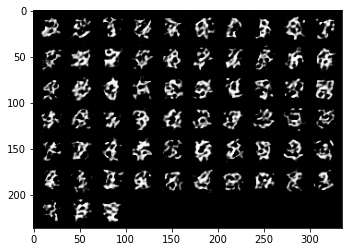

avg_kl_d 1.8396928
is_score 6.2946043



avg_kl_d 1.7237303
is_score 5.6054



avg_kl_d 2.0784516
is_score 7.9920855



avg_kl_d 1.862724
is_score 6.441259



avg_kl_d 1.8963118
is_score 6.6612806



avg_kl_d 2.1130617
is_score 8.273533



avg_kl_d 1.9399513
is_score 6.958412



avg_kl_d 1.8980806
is_score 6.673074



avg_kl_d 2.1496518
is_score 8.581869



avg_kl_d 1.8808155
is_score 6.5588512



Epoch: [25] [  50/ 200] D_loss: 4.11383724, G_loss: 0.07309055
Epoch: [25] [ 100/ 200] D_loss: 5.43893957, G_loss: 0.08367527
Epoch: [25] [ 150/ 200] D_loss: 3.54352617, G_loss: 0.07678992
Epoch: [25] [ 200/ 200] D_loss: 3.49039006, G_loss: 0.08130854
Training at Epoch:
24


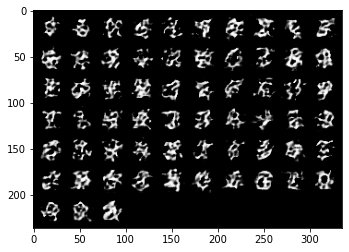

avg_kl_d 2.0354917
is_score 7.656016



avg_kl_d 2.006648
is_score 7.4383426



avg_kl_d 1.933292
is_score 6.9122286



avg_kl_d 1.9011284
is_score 6.6934433



avg_kl_d 1.7996441
is_score 6.047495



avg_kl_d 1.8997755
is_score 6.684394



avg_kl_d 2.0465777
is_score 7.741362



avg_kl_d 1.987442
is_score 7.296845



avg_kl_d 1.8760011
is_score 6.52735



avg_kl_d 1.9812193
is_score 7.2515793



Epoch: [26] [  50/ 200] D_loss: 6.36291838, G_loss: 0.09984332
Epoch: [26] [ 100/ 200] D_loss: 2.85075521, G_loss: 0.09744936
Epoch: [26] [ 150/ 200] D_loss: 4.73304129, G_loss: 0.09433407
Epoch: [26] [ 200/ 200] D_loss: 4.40309715, G_loss: 0.09106880
Training at Epoch:
25


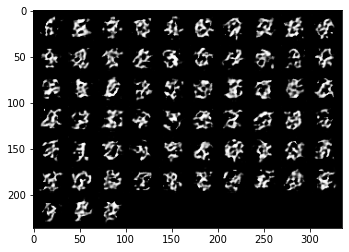

avg_kl_d 2.0520897
is_score 7.7841506



avg_kl_d 1.9744734
is_score 7.202825



avg_kl_d 1.8293642
is_score 6.2299247



avg_kl_d 1.85816
is_score 6.4119277



avg_kl_d 1.9436979
is_score 6.9845314



avg_kl_d 2.0293555
is_score 7.609181



avg_kl_d 1.9646391
is_score 7.132338



avg_kl_d 2.0543735
is_score 7.8019485



avg_kl_d 1.8903687
is_score 6.6218095



avg_kl_d 1.9543467
is_score 7.059305



Epoch: [27] [  50/ 200] D_loss: 2.85559392, G_loss: 0.10293579
Epoch: [27] [ 100/ 200] D_loss: 3.97441864, G_loss: 0.09907484
Epoch: [27] [ 150/ 200] D_loss: 5.46872759, G_loss: 0.09959030
Epoch: [27] [ 200/ 200] D_loss: 5.64939594, G_loss: 0.07760388
Training at Epoch:
26


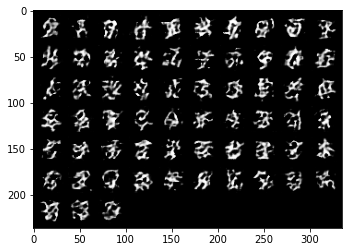

avg_kl_d 1.8974358
is_score 6.668772



avg_kl_d 2.0788157
is_score 7.9949946



avg_kl_d 1.9356
is_score 6.9282



avg_kl_d 1.7934694
is_score 6.010268



avg_kl_d 1.9851376
is_score 7.280049



avg_kl_d 2.1001275
is_score 8.167211



avg_kl_d 1.9307674
is_score 6.8947988



avg_kl_d 2.1337783
is_score 8.446721



avg_kl_d 1.8206583
is_score 6.175923



avg_kl_d 1.9167881
is_score 6.799085



Epoch: [28] [  50/ 200] D_loss: 2.56882930, G_loss: 0.09051520
Epoch: [28] [ 100/ 200] D_loss: 5.21425295, G_loss: 0.10063517
Epoch: [28] [ 150/ 200] D_loss: 3.92661476, G_loss: 0.10170501
Epoch: [28] [ 200/ 200] D_loss: 5.92404461, G_loss: 0.10939991
Training at Epoch:
27


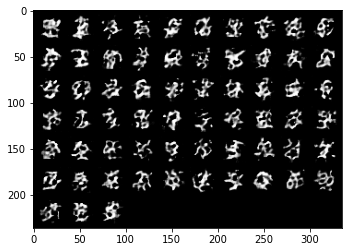

avg_kl_d 2.0496
is_score 7.764794



avg_kl_d 1.977026
is_score 7.2212343



avg_kl_d 1.9921417
is_score 7.3312187



avg_kl_d 2.0308952
is_score 7.620906



avg_kl_d 2.032809
is_score 7.6355047



avg_kl_d 2.0057476
is_score 7.431648



avg_kl_d 1.9745051
is_score 7.2030535



avg_kl_d 2.0729473
is_score 7.9482145



avg_kl_d 2.1097012
is_score 8.245777



avg_kl_d 2.0033739
is_score 7.4140277



Epoch: [29] [  50/ 200] D_loss: 4.89852810, G_loss: 0.10494506
Epoch: [29] [ 100/ 200] D_loss: 7.20670605, G_loss: 0.12229067
Epoch: [29] [ 150/ 200] D_loss: 4.51994467, G_loss: 0.11913878
Epoch: [29] [ 200/ 200] D_loss: 3.71998525, G_loss: 0.10886121
Training at Epoch:
28


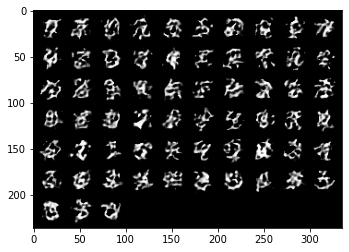

avg_kl_d 1.9907677
is_score 7.321152



avg_kl_d 1.9613365
is_score 7.108822



avg_kl_d 1.9306653
is_score 6.8940954



avg_kl_d 1.9047964
is_score 6.718039



avg_kl_d 1.971125
is_score 7.1787477



avg_kl_d 1.7036333
is_score 5.493872



avg_kl_d 2.1886306
is_score 8.922986



avg_kl_d 2.154258
is_score 8.6214905



avg_kl_d 2.1055546
is_score 8.211656



avg_kl_d 1.8504356
is_score 6.3625903



Epoch: [30] [  50/ 200] D_loss: 4.39310265, G_loss: 0.12879497
Epoch: [30] [ 100/ 200] D_loss: 4.42644167, G_loss: 0.13412499
Epoch: [30] [ 150/ 200] D_loss: 3.63703012, G_loss: 0.12755603
Epoch: [30] [ 200/ 200] D_loss: 5.93087578, G_loss: 0.15700722
Training at Epoch:
29


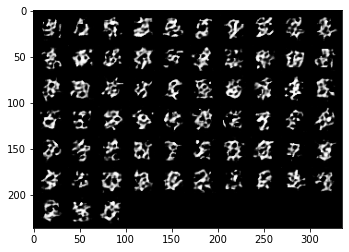

avg_kl_d 1.7902359
is_score 5.990865



avg_kl_d 1.7872877
is_score 5.9732294



avg_kl_d 2.0362716
is_score 7.6619887



avg_kl_d 1.8945873
is_score 6.649803



avg_kl_d 2.0212636
is_score 7.547856



avg_kl_d 1.9666284
is_score 7.1465406



avg_kl_d 1.7970827
is_score 6.032024



avg_kl_d 2.0085318
is_score 7.4523683



avg_kl_d 1.6769726
is_score 5.349337



avg_kl_d 2.0813131
is_score 8.014987



Epoch: [31] [  50/ 200] D_loss: 4.60771561, G_loss: 0.15559989
Epoch: [31] [ 100/ 200] D_loss: 5.02678680, G_loss: 0.15165383
Epoch: [31] [ 150/ 200] D_loss: 3.78617954, G_loss: 0.14043468
Epoch: [31] [ 200/ 200] D_loss: 3.57905650, G_loss: 0.14894325
Training at Epoch:
30


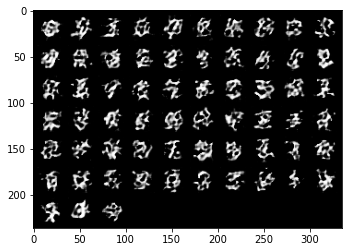

avg_kl_d 1.9618435
is_score 7.1124268



avg_kl_d 1.8636701
is_score 6.4473557



avg_kl_d 1.8745123
is_score 6.5176396



avg_kl_d 2.1417005
is_score 8.513904



avg_kl_d 2.0314345
is_score 7.625016



avg_kl_d 1.8684003
is_score 6.477926



avg_kl_d 2.089379
is_score 8.079897



avg_kl_d 1.9810174
is_score 7.250115



avg_kl_d 1.997344
is_score 7.3694572



avg_kl_d 1.9751745
is_score 7.207878



Epoch: [32] [  50/ 200] D_loss: 4.25283051, G_loss: 0.15246755
Epoch: [32] [ 100/ 200] D_loss: 4.66269588, G_loss: 0.13941020
Epoch: [32] [ 150/ 200] D_loss: 3.51765919, G_loss: 0.13482088
Epoch: [32] [ 200/ 200] D_loss: 4.97358036, G_loss: 0.14276445
Training at Epoch:
31


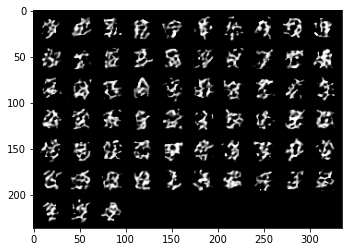

avg_kl_d 1.8724477
is_score 6.5041976



avg_kl_d 2.0456464
is_score 7.734157



avg_kl_d 2.0207174
is_score 7.543735



avg_kl_d 2.0807118
is_score 8.010169



avg_kl_d 1.8636049
is_score 6.446935



avg_kl_d 1.8276336
is_score 6.219152



avg_kl_d 1.9577177
is_score 7.0831428



avg_kl_d 1.9816759
is_score 7.2548914



avg_kl_d 1.8930613
is_score 6.639663



avg_kl_d 1.910516
is_score 6.7565746



Epoch: [33] [  50/ 200] D_loss: 3.62191057, G_loss: 0.14762086
Epoch: [33] [ 100/ 200] D_loss: 4.18061399, G_loss: 0.16327125
Epoch: [33] [ 150/ 200] D_loss: 2.52457500, G_loss: 0.14870936
Epoch: [33] [ 200/ 200] D_loss: 3.71518397, G_loss: 0.16917717
Training at Epoch:
32


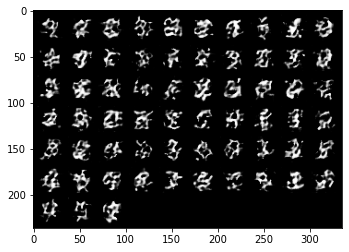

avg_kl_d 2.0873125
is_score 8.063215



avg_kl_d 1.9570148
is_score 7.078166



avg_kl_d 1.8843304
is_score 6.581946



avg_kl_d 2.046809
is_score 7.743153



avg_kl_d 1.9244341
is_score 6.8512697



avg_kl_d 1.9847975
is_score 7.2775736



avg_kl_d 1.6823885
is_score 5.3783875



avg_kl_d 1.9973154
is_score 7.369246



avg_kl_d 2.0844116
is_score 8.03986



avg_kl_d 2.1439188
is_score 8.53281



Epoch: [34] [  50/ 200] D_loss: 5.99059248, G_loss: 0.16157424
Epoch: [34] [ 100/ 200] D_loss: 2.46133900, G_loss: 0.16531003
Epoch: [34] [ 150/ 200] D_loss: 3.30603456, G_loss: 0.18989843
Epoch: [34] [ 200/ 200] D_loss: 3.72156262, G_loss: 0.17894238
Training at Epoch:
33


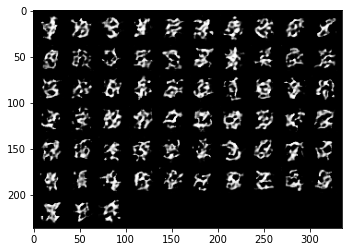

avg_kl_d 2.0699403
is_score 7.9243507



avg_kl_d 1.7876196
is_score 5.9752116



avg_kl_d 2.0607393
is_score 7.8517723



avg_kl_d 1.8869486
is_score 6.599201



avg_kl_d 1.9292634
is_score 6.884437



avg_kl_d 2.0473185
is_score 7.747099



avg_kl_d 1.9225308
is_score 6.8382425



avg_kl_d 1.9315151
is_score 6.8999557



avg_kl_d 1.9525454
is_score 7.0466013



avg_kl_d 1.8746392
is_score 6.518467



Epoch: [35] [  50/ 200] D_loss: 4.06963778, G_loss: 0.17976296
Epoch: [35] [ 100/ 200] D_loss: 2.55065060, G_loss: 0.18250054
Epoch: [35] [ 150/ 200] D_loss: 3.09397030, G_loss: 0.19166219
Epoch: [35] [ 200/ 200] D_loss: 3.70845699, G_loss: 0.19737834
Training at Epoch:
34


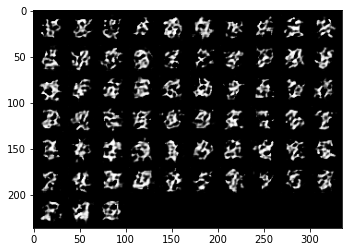

avg_kl_d 2.027221
is_score 7.592956



avg_kl_d 2.0759392
is_score 7.97203



avg_kl_d 1.9365718
is_score 6.9349356



avg_kl_d 1.9737291
is_score 7.197467



avg_kl_d 2.1391294
is_score 8.492041



avg_kl_d 2.0692587
is_score 7.9189506



avg_kl_d 2.0190902
is_score 7.53147



avg_kl_d 1.9813026
is_score 7.2521834



avg_kl_d 2.107999
is_score 8.231753



avg_kl_d 2.190185
is_score 8.936867



Epoch: [36] [  50/ 200] D_loss: 4.90795422, G_loss: 0.20853138
Epoch: [36] [ 100/ 200] D_loss: 3.45092416, G_loss: 0.20352638
Epoch: [36] [ 150/ 200] D_loss: 2.94815302, G_loss: 0.23556888
Epoch: [36] [ 200/ 200] D_loss: 4.21198130, G_loss: 0.21303010
Training at Epoch:
35


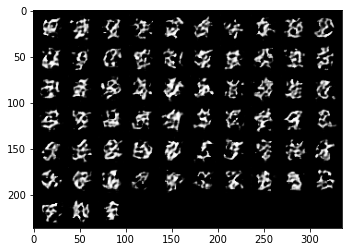

avg_kl_d 1.9141188
is_score 6.7809606



avg_kl_d 2.25666
is_score 9.551135



avg_kl_d 2.1473434
is_score 8.562082



avg_kl_d 1.8657262
is_score 6.4606256



avg_kl_d 1.8799852
is_score 6.5534077



avg_kl_d 2.1285434
is_score 8.402618



avg_kl_d 1.9272835
is_score 6.8708205



avg_kl_d 2.0714302
is_score 7.9361653



avg_kl_d 1.9369743
is_score 6.9377275



avg_kl_d 2.1594663
is_score 8.666512



Epoch: [37] [  50/ 200] D_loss: 1.75150275, G_loss: 0.22016412
Epoch: [37] [ 100/ 200] D_loss: 2.04336667, G_loss: 0.23093754
Epoch: [37] [ 150/ 200] D_loss: 7.33158588, G_loss: 0.20723599
Epoch: [37] [ 200/ 200] D_loss: 2.72320747, G_loss: 0.22415161
Training at Epoch:
36


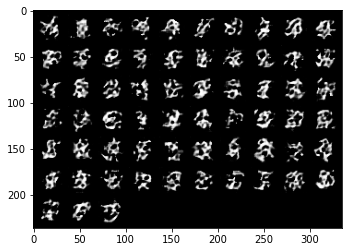

avg_kl_d 2.13992
is_score 8.498758



avg_kl_d 2.0318878
is_score 7.6284738



avg_kl_d 2.046083
is_score 7.7375336



avg_kl_d 1.8335679
is_score 6.2561674



avg_kl_d 1.9884021
is_score 7.303854



avg_kl_d 2.094656
is_score 8.122646



avg_kl_d 1.8691019
is_score 6.4824715



avg_kl_d 2.0896082
is_score 8.081748



avg_kl_d 1.9924314
is_score 7.333342



avg_kl_d 1.9332812
is_score 6.912153



Epoch: [38] [  50/ 200] D_loss: 3.59226251, G_loss: 0.20996559
Epoch: [38] [ 100/ 200] D_loss: 4.56839466, G_loss: 0.23093075
Epoch: [38] [ 150/ 200] D_loss: 3.45335293, G_loss: 0.22667676
Epoch: [38] [ 200/ 200] D_loss: 2.14396644, G_loss: 0.23565304
Training at Epoch:
37


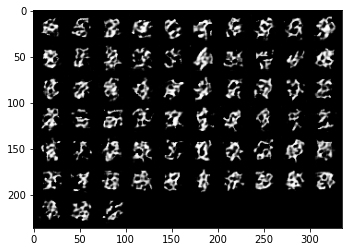

avg_kl_d 2.1418376
is_score 8.515071



avg_kl_d 2.0984335
is_score 8.153388



avg_kl_d 1.9105356
is_score 6.756706



avg_kl_d 2.0057926
is_score 7.431983



avg_kl_d 2.0047696
is_score 7.424383



avg_kl_d 1.9994793
is_score 7.38521



avg_kl_d 2.0486252
is_score 7.7572293



avg_kl_d 1.9566288
is_score 7.075434



avg_kl_d 2.0012352
is_score 7.398189



avg_kl_d 1.9072367
is_score 6.734453



Epoch: [39] [  50/ 200] D_loss: 2.13101673, G_loss: 0.22816795
Epoch: [39] [ 100/ 200] D_loss: 5.71778870, G_loss: 0.28341481
Epoch: [39] [ 150/ 200] D_loss: 4.25216293, G_loss: 0.26871794
Epoch: [39] [ 200/ 200] D_loss: 2.50527930, G_loss: 0.25687742
Training at Epoch:
38


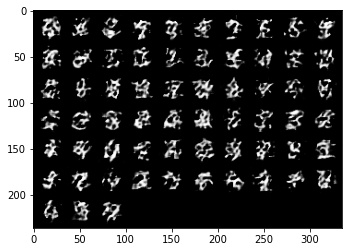

avg_kl_d 2.0644717
is_score 7.881133



avg_kl_d 1.9473025
is_score 7.0097528



avg_kl_d 2.128869
is_score 8.405355



avg_kl_d 1.7998607
is_score 6.0488048



avg_kl_d 1.9843934
is_score 7.274633



avg_kl_d 1.8948314
is_score 6.651427



avg_kl_d 1.8291461
is_score 6.2285657



avg_kl_d 1.8648188
is_score 6.454766



avg_kl_d 2.0151925
is_score 7.502171



avg_kl_d 1.9652462
is_score 7.136669



Epoch: [40] [  50/ 200] D_loss: 5.94779730, G_loss: 0.24593228
Epoch: [40] [ 100/ 200] D_loss: 1.95589352, G_loss: 0.26081711
Epoch: [40] [ 150/ 200] D_loss: 2.55394793, G_loss: 0.27832255
Epoch: [40] [ 200/ 200] D_loss: 4.62208986, G_loss: 0.28884050
Training at Epoch:
39


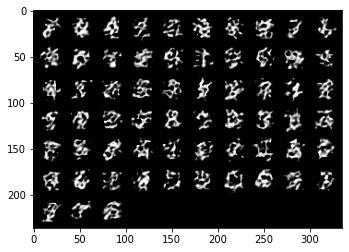

avg_kl_d 2.0869906
is_score 8.060621



avg_kl_d 2.046134
is_score 7.737928



avg_kl_d 1.9994881
is_score 7.3852744



avg_kl_d 2.0138633
is_score 7.492206



avg_kl_d 2.0357335
is_score 7.6578665



avg_kl_d 1.94673
is_score 7.005741



avg_kl_d 1.9629561
is_score 7.1203437



avg_kl_d 1.9451996
is_score 6.9950275



avg_kl_d 2.0600758
is_score 7.8465643



avg_kl_d 2.188858
is_score 8.925015



Epoch: [41] [  50/ 200] D_loss: 3.19235158, G_loss: 0.28714794
Epoch: [41] [ 100/ 200] D_loss: 3.29078197, G_loss: 0.25257826
Epoch: [41] [ 150/ 200] D_loss: 6.79418373, G_loss: 0.28792918
Epoch: [41] [ 200/ 200] D_loss: 1.83829737, G_loss: 0.26293933
Training at Epoch:
40


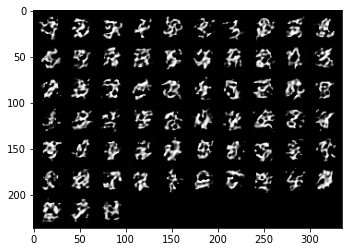

avg_kl_d 1.9424574
is_score 6.9758725



avg_kl_d 1.9975315
is_score 7.370839



avg_kl_d 1.9950956
is_score 7.352906



avg_kl_d 1.8389585
is_score 6.2899833



avg_kl_d 2.140428
is_score 8.503077



avg_kl_d 2.0773888
is_score 7.9835944



avg_kl_d 1.9497744
is_score 7.027102



avg_kl_d 2.051001
is_score 7.775681



avg_kl_d 1.8403809
is_score 6.298937



avg_kl_d 2.128884
is_score 8.405481



Epoch: [42] [  50/ 200] D_loss: 2.25064087, G_loss: 0.29753885
Epoch: [42] [ 100/ 200] D_loss: 4.75178623, G_loss: 0.28079289
Epoch: [42] [ 150/ 200] D_loss: 2.15192628, G_loss: 0.29052135
Epoch: [42] [ 200/ 200] D_loss: 3.09530330, G_loss: 0.30819517
Training at Epoch:
41


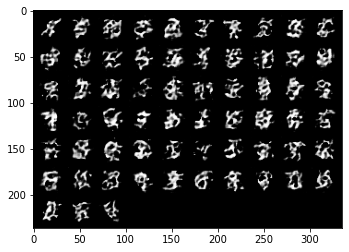

avg_kl_d 2.0560367
is_score 7.814935



avg_kl_d 2.1128953
is_score 8.272157



avg_kl_d 1.8260443
is_score 6.209276



avg_kl_d 2.1237843
is_score 8.362724



avg_kl_d 2.0823889
is_score 8.023614



avg_kl_d 1.8292049
is_score 6.2289324



avg_kl_d 2.0555162
is_score 7.810869



avg_kl_d 1.9792938
is_score 7.237631



avg_kl_d 2.0253556
is_score 7.5788054



avg_kl_d 2.1970508
is_score 8.998436



Epoch: [43] [  50/ 200] D_loss: 1.34953558, G_loss: 0.27589941
Epoch: [43] [ 100/ 200] D_loss: 6.34972763, G_loss: 0.31207353
Epoch: [43] [ 150/ 200] D_loss: 2.05556107, G_loss: 0.30826071
Epoch: [43] [ 200/ 200] D_loss: 4.53433418, G_loss: 0.30245030
Training at Epoch:
42


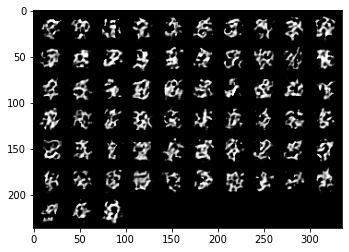

avg_kl_d 1.7900398
is_score 5.9896903



avg_kl_d 2.1151338
is_score 8.290694



avg_kl_d 2.0380356
is_score 7.675517



avg_kl_d 2.0467353
is_score 7.742583



avg_kl_d 1.9598786
is_score 7.098465



avg_kl_d 1.5208527
is_score 4.576125



avg_kl_d 2.0849829
is_score 8.044454



avg_kl_d 2.0936701
is_score 8.114642



avg_kl_d 2.1400006
is_score 8.499443



avg_kl_d 1.8922342
is_score 6.634174



Epoch: [44] [  50/ 200] D_loss: 3.23028898, G_loss: 0.31726906
Epoch: [44] [ 100/ 200] D_loss: 2.57870388, G_loss: 0.30897051
Epoch: [44] [ 150/ 200] D_loss: 2.59978390, G_loss: 0.33162972
Epoch: [44] [ 200/ 200] D_loss: 3.08964872, G_loss: 0.30704266
Training at Epoch:
43


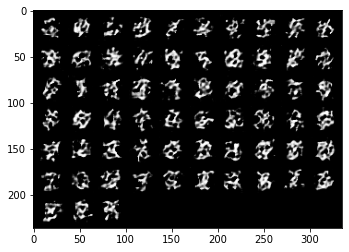

avg_kl_d 1.826197
is_score 6.210224



avg_kl_d 2.1791394
is_score 8.838696



avg_kl_d 1.7421763
is_score 5.7097564



avg_kl_d 2.1733305
is_score 8.787502



avg_kl_d 1.8982584
is_score 6.6742606



avg_kl_d 2.0109549
is_score 7.470447



avg_kl_d 2.098939
is_score 8.15751



avg_kl_d 1.824062
is_score 6.1969795



avg_kl_d 2.0668764
is_score 7.900108



avg_kl_d 2.0207934
is_score 7.5443087



Epoch: [45] [  50/ 200] D_loss: 3.50357985, G_loss: 0.32383615
Epoch: [45] [ 100/ 200] D_loss: 8.10303783, G_loss: 0.35192862
Epoch: [45] [ 150/ 200] D_loss: 3.71586490, G_loss: 0.34135309
Epoch: [45] [ 200/ 200] D_loss: 1.81981564, G_loss: 0.34031981
Training at Epoch:
44


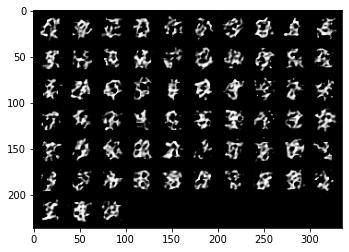

avg_kl_d 2.065414
is_score 7.888563



avg_kl_d 1.8576832
is_score 6.408871



avg_kl_d 1.9945347
is_score 7.348783



avg_kl_d 1.969668
is_score 7.1682963



avg_kl_d 1.9932282
is_score 7.3391876



avg_kl_d 1.8943841
is_score 6.6484523



avg_kl_d 1.8114223
is_score 6.119145



avg_kl_d 1.8918775
is_score 6.6318083



avg_kl_d 1.9355862
is_score 6.928104



avg_kl_d 2.0347097
is_score 7.650031



Epoch: [46] [  50/ 200] D_loss: 1.69718552, G_loss: 0.34056330
Epoch: [46] [ 100/ 200] D_loss: 3.23085904, G_loss: 0.33952421
Epoch: [46] [ 150/ 200] D_loss: 3.57083702, G_loss: 0.31023228
Epoch: [46] [ 200/ 200] D_loss: 2.46512294, G_loss: 0.36461529
Training at Epoch:
45


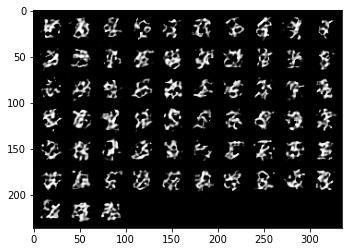

avg_kl_d 1.8193896
is_score 6.1680923



avg_kl_d 2.0559158
is_score 7.8139906



avg_kl_d 1.7916054
is_score 5.999075



avg_kl_d 1.9341437
is_score 6.9181175



avg_kl_d 2.1383767
is_score 8.485652



avg_kl_d 2.0731888
is_score 7.950134



avg_kl_d 1.8638823
is_score 6.448724



avg_kl_d 1.8782587
is_score 6.542103



avg_kl_d 1.8618473
is_score 6.435614



avg_kl_d 2.2061927
is_score 9.081077



Epoch: [47] [  50/ 200] D_loss: 1.66511631, G_loss: 0.33404785
Epoch: [47] [ 100/ 200] D_loss: 2.86148691, G_loss: 0.34919742
Epoch: [47] [ 150/ 200] D_loss: 3.73383379, G_loss: 0.34211919
Epoch: [47] [ 200/ 200] D_loss: 4.05361271, G_loss: 0.35328960
Training at Epoch:
46


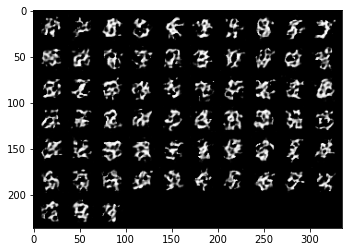

avg_kl_d 1.8131554
is_score 6.129759



avg_kl_d 1.8970846
is_score 6.6664305



avg_kl_d 2.1388116
is_score 8.489343



avg_kl_d 1.9869633
is_score 7.293352



avg_kl_d 1.8332208
is_score 6.2539973



avg_kl_d 1.9717963
is_score 7.183569



avg_kl_d 1.8806826
is_score 6.55798



avg_kl_d 1.8563646
is_score 6.4004264



avg_kl_d 1.8346157
is_score 6.262727



avg_kl_d 2.0261867
is_score 7.585107



Epoch: [48] [  50/ 200] D_loss: 1.62752199, G_loss: 0.38688332
Epoch: [48] [ 100/ 200] D_loss: 1.86613774, G_loss: 0.38045144
Epoch: [48] [ 150/ 200] D_loss: 4.24655771, G_loss: 0.38148749
Epoch: [48] [ 200/ 200] D_loss: 3.58306170, G_loss: 0.38652167
Training at Epoch:
47


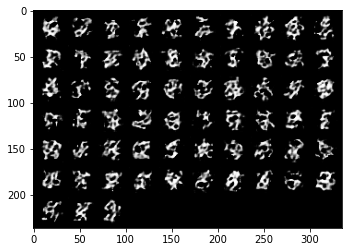

avg_kl_d 1.8487797
is_score 6.3520637



avg_kl_d 2.1013215
is_score 8.176969



avg_kl_d 1.9795437
is_score 7.2394385



avg_kl_d 2.1303062
is_score 8.417444



avg_kl_d 2.0755951
is_score 7.969288



avg_kl_d 1.9210026
is_score 6.8278008



avg_kl_d 2.0245748
is_score 7.57289



avg_kl_d 1.8497779
is_score 6.358407



avg_kl_d 2.063192
is_score 7.8710537



avg_kl_d 2.030699
is_score 7.61941



Epoch: [49] [  50/ 200] D_loss: 2.16603231, G_loss: 0.37914407
Epoch: [49] [ 100/ 200] D_loss: 6.48972321, G_loss: 0.38920468
Epoch: [49] [ 150/ 200] D_loss: 2.69444919, G_loss: 0.39049429
Epoch: [49] [ 200/ 200] D_loss: 1.61380208, G_loss: 0.35155234
Training at Epoch:
48


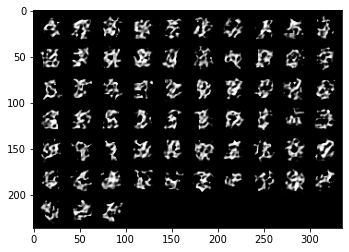

avg_kl_d 2.136338
is_score 8.4683695



avg_kl_d 2.0510738
is_score 7.776247



avg_kl_d 1.8918579
is_score 6.631678



avg_kl_d 2.0829167
is_score 8.02785



avg_kl_d 1.9100682
is_score 6.7535486



avg_kl_d 1.9155117
is_score 6.790413



avg_kl_d 2.1661885
is_score 8.724965



avg_kl_d 1.9250984
is_score 6.8558235



avg_kl_d 2.0726836
is_score 7.9461184



avg_kl_d 2.0473742
is_score 7.7475314



Epoch: [50] [  50/ 200] D_loss: 1.58535755, G_loss: 0.38002798
Epoch: [50] [ 100/ 200] D_loss: 2.78247452, G_loss: 0.39075908
Epoch: [50] [ 150/ 200] D_loss: 3.54483438, G_loss: 0.39984936
Epoch: [50] [ 200/ 200] D_loss: 1.27370310, G_loss: 0.36965534
Training at Epoch:
49


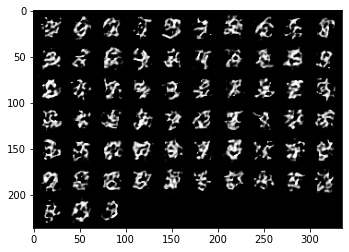

avg_kl_d 1.9480671
is_score 7.015115



avg_kl_d 2.1249988
is_score 8.372888



avg_kl_d 2.1103592
is_score 8.2512045



avg_kl_d 2.1593213
is_score 8.665255



avg_kl_d 2.0992734
is_score 8.160238



avg_kl_d 2.121228
is_score 8.341374



avg_kl_d 2.046474
is_score 7.7405596



avg_kl_d 2.0679574
is_score 7.908653



avg_kl_d 1.9987342
is_score 7.3797092



avg_kl_d 1.9816897
is_score 7.254991



Epoch: [51] [  50/ 200] D_loss: 1.73488808, G_loss: 0.40202338
Epoch: [51] [ 100/ 200] D_loss: 1.75867963, G_loss: 0.40920907
Epoch: [51] [ 150/ 200] D_loss: 2.38860369, G_loss: 0.40612683
Epoch: [51] [ 200/ 200] D_loss: 2.36448002, G_loss: 0.40423784
Training at Epoch:
50


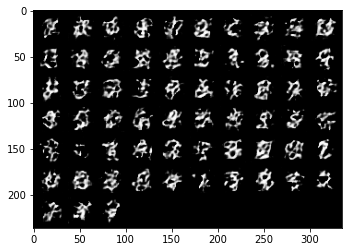

avg_kl_d 1.8156538
is_score 6.145092



avg_kl_d 2.1061432
is_score 8.216491



avg_kl_d 2.0394015
is_score 7.686008



avg_kl_d 1.853173
is_score 6.380031



avg_kl_d 1.9718158
is_score 7.1837087



avg_kl_d 2.1426854
is_score 8.522293



avg_kl_d 1.9447396
is_score 6.991811



avg_kl_d 2.030601
is_score 7.6186633



avg_kl_d 2.0804784
is_score 8.008299



avg_kl_d 1.9266825
is_score 6.8666916



Epoch: [52] [  50/ 200] D_loss: 5.17688560, G_loss: 0.42726266
Epoch: [52] [ 100/ 200] D_loss: 5.99158192, G_loss: 0.41105944
Epoch: [52] [ 150/ 200] D_loss: 4.73344278, G_loss: 0.44187132
Epoch: [52] [ 200/ 200] D_loss: 2.60959768, G_loss: 0.42396185
Training at Epoch:
51


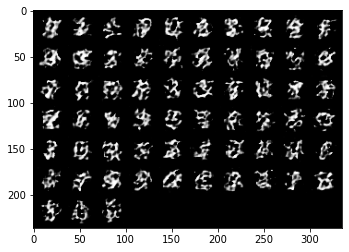

avg_kl_d 1.9356899
is_score 6.928823



avg_kl_d 1.9579777
is_score 7.0849843



avg_kl_d 1.698939
is_score 5.4681425



avg_kl_d 1.8099219
is_score 6.10997



avg_kl_d 2.0386007
is_score 7.6798553



avg_kl_d 1.8794172
is_score 6.549687



avg_kl_d 2.0092244
is_score 7.4575315



avg_kl_d 1.9961603
is_score 7.3607383



avg_kl_d 1.9809558
is_score 7.249669



avg_kl_d 1.8531883
is_score 6.3801284



Epoch: [53] [  50/ 200] D_loss: 4.02853394, G_loss: 0.41673774
Epoch: [53] [ 100/ 200] D_loss: 3.04094410, G_loss: 0.46047735
Epoch: [53] [ 150/ 200] D_loss: 4.11837959, G_loss: 0.44489464
Epoch: [53] [ 200/ 200] D_loss: 2.21810102, G_loss: 0.45197353
Training at Epoch:
52


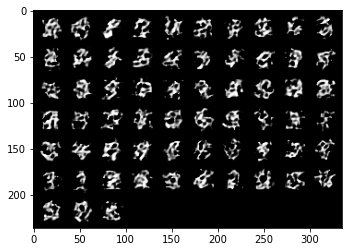

avg_kl_d 2.0085073
is_score 7.452185



avg_kl_d 2.0950904
is_score 8.126176



avg_kl_d 2.1235893
is_score 8.3610935



avg_kl_d 1.8027604
is_score 6.066369



avg_kl_d 1.9220645
is_score 6.835055



avg_kl_d 1.9196985
is_score 6.8189015



avg_kl_d 2.175483
is_score 8.806438



avg_kl_d 1.8554542
is_score 6.3946023



avg_kl_d 1.751783
is_score 5.7648716



avg_kl_d 1.8981569
is_score 6.6735826



Epoch: [54] [  50/ 200] D_loss: 1.10380816, G_loss: 0.45785141
Epoch: [54] [ 100/ 200] D_loss: 2.15907025, G_loss: 0.47465047
Epoch: [54] [ 150/ 200] D_loss: 5.62544441, G_loss: 0.44366744
Epoch: [54] [ 200/ 200] D_loss: 3.09650850, G_loss: 0.43637645
Training at Epoch:
53


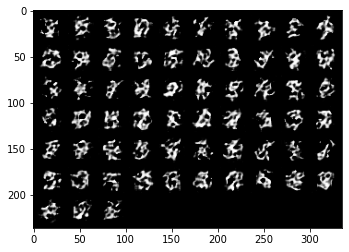

avg_kl_d 2.0494466
is_score 7.763603



avg_kl_d 1.9757954
is_score 7.2123537



avg_kl_d 1.9246708
is_score 6.8528924



avg_kl_d 1.9820827
is_score 7.257843



avg_kl_d 1.9976124
is_score 7.3714347



avg_kl_d 2.0622406
is_score 7.8635693



avg_kl_d 1.9819803
is_score 7.2571006



avg_kl_d 2.201187
is_score 9.035731



avg_kl_d 1.9129006
is_score 6.7727046



avg_kl_d 1.8258512
is_score 6.2080774



Epoch: [55] [  50/ 200] D_loss: 8.17846966, G_loss: 0.45681244
Epoch: [55] [ 100/ 200] D_loss: 2.12542844, G_loss: 0.48035750
Epoch: [55] [ 150/ 200] D_loss: 1.43815422, G_loss: 0.43395588
Epoch: [55] [ 200/ 200] D_loss: 1.70594001, G_loss: 0.42048365
Training at Epoch:
54


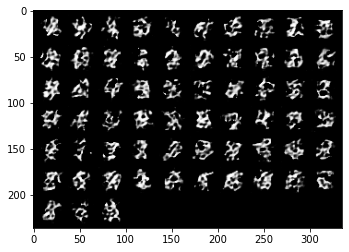

avg_kl_d 2.1202326
is_score 8.333076



avg_kl_d 2.018395
is_score 7.526235



avg_kl_d 1.9191481
is_score 6.81515



avg_kl_d 1.9428871
is_score 6.9788704



avg_kl_d 1.8207363
is_score 6.176404



avg_kl_d 2.0079198
is_score 7.4478083



avg_kl_d 1.9473816
is_score 7.010308



avg_kl_d 1.9494377
is_score 7.024737



avg_kl_d 1.9423517
is_score 6.975135



avg_kl_d 2.0410082
is_score 7.698367



Epoch: [56] [  50/ 200] D_loss: 1.66777563, G_loss: 0.45835772
Epoch: [56] [ 100/ 200] D_loss: 1.91359711, G_loss: 0.46430606
Epoch: [56] [ 150/ 200] D_loss: 2.51439381, G_loss: 0.46726882
Epoch: [56] [ 200/ 200] D_loss: 1.68829572, G_loss: 0.46279326
Training at Epoch:
55


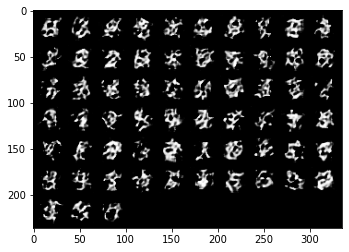

avg_kl_d 2.1582184
is_score 8.655703



avg_kl_d 2.1262808
is_score 8.383628



avg_kl_d 1.9625013
is_score 7.1171064



avg_kl_d 2.065883
is_score 7.892263



avg_kl_d 2.1951363
is_score 8.981226



avg_kl_d 1.9941151
is_score 7.3457003



avg_kl_d 2.0053484
is_score 7.428682



avg_kl_d 1.9460087
is_score 7.00069



avg_kl_d 2.0743668
is_score 7.9595046



avg_kl_d 2.1131592
is_score 8.27434



Epoch: [57] [  50/ 200] D_loss: 4.70118427, G_loss: 0.50263727
Epoch: [57] [ 100/ 200] D_loss: 3.29306269, G_loss: 0.49913707
Epoch: [57] [ 150/ 200] D_loss: 1.51869941, G_loss: 0.51227480
Epoch: [57] [ 200/ 200] D_loss: 2.96792364, G_loss: 0.51163125
Training at Epoch:
56


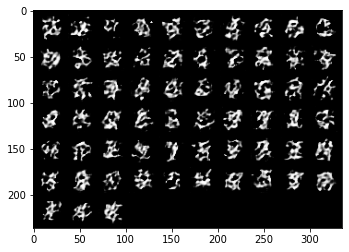

avg_kl_d 1.9812238
is_score 7.251612



avg_kl_d 2.0936444
is_score 8.114433



avg_kl_d 2.1490824
is_score 8.576984



avg_kl_d 2.0589938
is_score 7.8380795



avg_kl_d 1.9682299
is_score 7.1579947



avg_kl_d 1.9695518
is_score 7.1674633



avg_kl_d 2.043359
is_score 7.716486



avg_kl_d 1.9180683
is_score 6.8077946



avg_kl_d 2.0818791
is_score 8.019525



avg_kl_d 2.0224748
is_score 7.557004



Epoch: [58] [  50/ 200] D_loss: 3.22999740, G_loss: 0.48336071
Epoch: [58] [ 100/ 200] D_loss: 1.84582543, G_loss: 0.43008721
Epoch: [58] [ 150/ 200] D_loss: 4.02809477, G_loss: 0.54261708
Epoch: [58] [ 200/ 200] D_loss: 8.06773663, G_loss: 0.53645611
Training at Epoch:
57


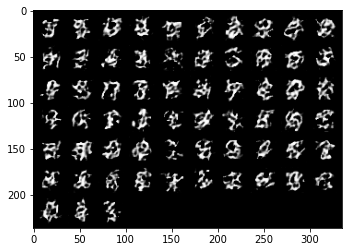

avg_kl_d 1.9786227
is_score 7.232774



avg_kl_d 1.9686081
is_score 7.1607027



avg_kl_d 1.9316431
is_score 6.90084



avg_kl_d 2.0422084
is_score 7.7076116



avg_kl_d 1.9946585
is_score 7.349693



avg_kl_d 2.006108
is_score 7.434327



avg_kl_d 2.0583386
is_score 7.8329453



avg_kl_d 1.9812095
is_score 7.251508



avg_kl_d 2.1744356
is_score 8.797218



avg_kl_d 2.0925431
is_score 8.105503



Epoch: [59] [  50/ 200] D_loss: 4.34016466, G_loss: 0.52843058
Epoch: [59] [ 100/ 200] D_loss: 1.32006955, G_loss: 0.51914066
Epoch: [59] [ 150/ 200] D_loss: 2.05743980, G_loss: 0.51200444
Epoch: [59] [ 200/ 200] D_loss: 2.51397324, G_loss: 0.52628052
Training at Epoch:
58


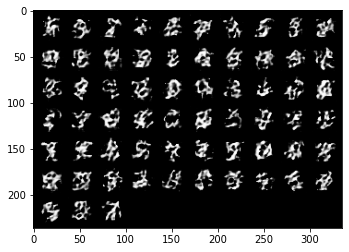

avg_kl_d 2.178636
is_score 8.8342495



avg_kl_d 2.0627763
is_score 7.8677826



avg_kl_d 2.0797765
is_score 8.002681



avg_kl_d 2.1196673
is_score 8.328366



avg_kl_d 1.8985243
is_score 6.676035



avg_kl_d 1.9937756
is_score 7.3432064



avg_kl_d 1.9665111
is_score 7.1457024



avg_kl_d 1.6575873
is_score 5.246637



avg_kl_d 1.9672086
is_score 7.1506877



avg_kl_d 2.179957
is_score 8.845925



Epoch: [60] [  50/ 200] D_loss: 1.21489012, G_loss: 0.52969182
Epoch: [60] [ 100/ 200] D_loss: 1.93972266, G_loss: 0.49192587
Epoch: [60] [ 150/ 200] D_loss: 1.27291656, G_loss: 0.46567371
Epoch: [60] [ 200/ 200] D_loss: 1.23826528, G_loss: 0.55371821
Training at Epoch:
59


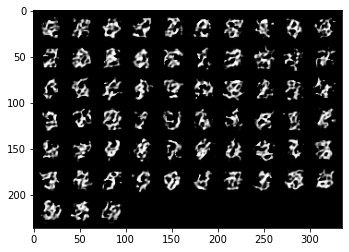

avg_kl_d 1.9193796
is_score 6.8167276



avg_kl_d 1.7981412
is_score 6.038413



avg_kl_d 2.1279037
is_score 8.397244



avg_kl_d 2.077232
is_score 7.9823422



avg_kl_d 1.9585167
is_score 7.0888047



avg_kl_d 1.963484
is_score 7.124104



avg_kl_d 1.9536097
is_score 7.0541043



avg_kl_d 2.0493493
is_score 7.7628484



avg_kl_d 1.9067122
is_score 6.730922



avg_kl_d 1.8926824
is_score 6.6371484



Epoch: [61] [  50/ 200] D_loss: 2.34162951, G_loss: 0.51194149
Epoch: [61] [ 100/ 200] D_loss: 2.82161546, G_loss: 0.55918926
Epoch: [61] [ 150/ 200] D_loss: 3.45233822, G_loss: 0.53544807
Epoch: [61] [ 200/ 200] D_loss: 1.62695336, G_loss: 0.53258026
Training at Epoch:
60


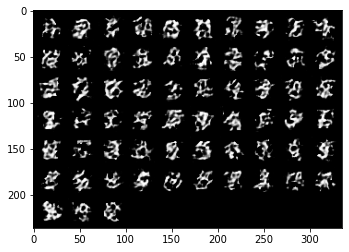

avg_kl_d 2.0740783
is_score 7.957209



avg_kl_d 1.8045629
is_score 6.0773144



avg_kl_d 1.852712
is_score 6.377091



avg_kl_d 1.9916872
is_score 7.327887



avg_kl_d 2.0387995
is_score 7.681382



avg_kl_d 2.1688492
is_score 8.748211



avg_kl_d 1.7625529
is_score 5.8272943



avg_kl_d 1.8456202
is_score 6.332025



avg_kl_d 1.9853789
is_score 7.2818055



avg_kl_d 1.8576374
is_score 6.4085774



Epoch: [62] [  50/ 200] D_loss: 1.48745322, G_loss: 0.52573830
Epoch: [62] [ 100/ 200] D_loss: 1.79995239, G_loss: 0.52628553
Epoch: [62] [ 150/ 200] D_loss: 1.28075945, G_loss: 0.58893096
Epoch: [62] [ 200/ 200] D_loss: 1.43689728, G_loss: 0.58244133
Training at Epoch:
61


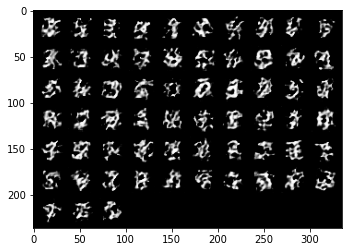

avg_kl_d 2.0050046
is_score 7.4261284



avg_kl_d 2.082124
is_score 8.021488



avg_kl_d 1.9541748
is_score 7.0580916



avg_kl_d 2.0247905
is_score 7.5745244



avg_kl_d 2.0877426
is_score 8.066685



avg_kl_d 1.9989979
is_score 7.381655



avg_kl_d 1.9312321
is_score 6.898004



avg_kl_d 1.9830816
is_score 7.2650967



avg_kl_d 2.1473458
is_score 8.562102



avg_kl_d 1.8614585
is_score 6.4331126



Epoch: [63] [  50/ 200] D_loss: 1.62048054, G_loss: 0.58178037
Epoch: [63] [ 100/ 200] D_loss: 1.07530904, G_loss: 0.58021396
Epoch: [63] [ 150/ 200] D_loss: 2.26403999, G_loss: 0.52265757
Epoch: [63] [ 200/ 200] D_loss: 2.30832934, G_loss: 0.57032657
Training at Epoch:
62


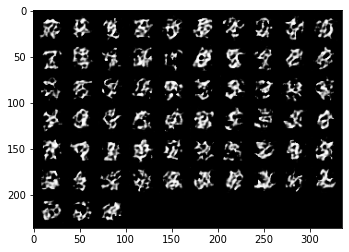

avg_kl_d 1.940095
is_score 6.959411



avg_kl_d 1.8740097
is_score 6.514365



avg_kl_d 2.129547
is_score 8.4110565



avg_kl_d 2.1062818
is_score 8.217629



avg_kl_d 1.9635665
is_score 7.124692



avg_kl_d 1.787973
is_score 5.977324



avg_kl_d 1.8711236
is_score 6.49559



avg_kl_d 2.1918454
is_score 8.951717



avg_kl_d 1.8701166
is_score 6.489053



avg_kl_d 1.7884481
is_score 5.9801645



Epoch: [64] [  50/ 200] D_loss: 2.00457525, G_loss: 0.57610029
Epoch: [64] [ 100/ 200] D_loss: 1.10766959, G_loss: 0.58561492
Epoch: [64] [ 150/ 200] D_loss: 1.05612111, G_loss: 0.53048337
Epoch: [64] [ 200/ 200] D_loss: 1.08016670, G_loss: 0.55053115
Training at Epoch:
63


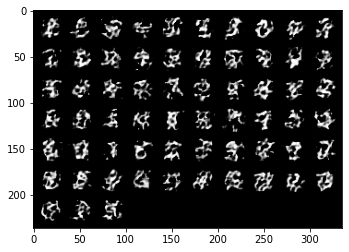

avg_kl_d 2.0842931
is_score 8.038907



avg_kl_d 1.9612579
is_score 7.1082635



avg_kl_d 1.8609037
is_score 6.429545



avg_kl_d 1.9760334
is_score 7.2140713



avg_kl_d 1.8682024
is_score 6.4766436



avg_kl_d 2.0793157
is_score 7.9989924



avg_kl_d 2.0223544
is_score 7.5560937



avg_kl_d 2.1336322
is_score 8.445486



avg_kl_d 2.046901
is_score 7.743866



avg_kl_d 2.0276585
is_score 7.596278



Epoch: [65] [  50/ 200] D_loss: 1.85612869, G_loss: 0.54531050
Epoch: [65] [ 100/ 200] D_loss: 1.88973999, G_loss: 0.54664880
Epoch: [65] [ 150/ 200] D_loss: 1.09151101, G_loss: 0.54391217
Epoch: [65] [ 200/ 200] D_loss: 1.39771485, G_loss: 0.60006142
Training at Epoch:
64


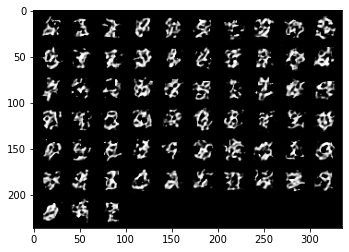

avg_kl_d 1.9775884
is_score 7.2252975



avg_kl_d 2.074636
is_score 7.961648



avg_kl_d 1.9610026
is_score 7.1064477



avg_kl_d 2.0445294
is_score 7.725522



avg_kl_d 1.822952
is_score 6.1901045



avg_kl_d 2.2181354
is_score 9.190178



avg_kl_d 1.9587682
is_score 7.090588



avg_kl_d 2.1582513
is_score 8.655988



avg_kl_d 1.8724401
is_score 6.504148



avg_kl_d 1.9502414
is_score 7.0303845



Epoch: [66] [  50/ 200] D_loss: 2.85596037, G_loss: 0.54046041
Epoch: [66] [ 100/ 200] D_loss: 1.22194195, G_loss: 0.58664238
Epoch: [66] [ 150/ 200] D_loss: 2.55355191, G_loss: 0.59350479
Epoch: [66] [ 200/ 200] D_loss: 4.20373297, G_loss: 0.60872239
Training at Epoch:
65


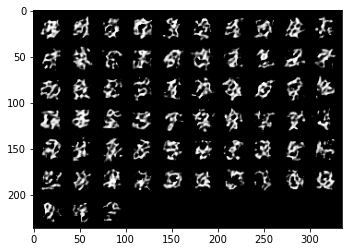

avg_kl_d 2.025498
is_score 7.5798845



avg_kl_d 1.940458
is_score 6.9619393



avg_kl_d 2.0081112
is_score 7.449234



avg_kl_d 1.8355548
is_score 6.2686114



avg_kl_d 1.7722912
is_score 5.8843193



avg_kl_d 1.8845713
is_score 6.5835314



avg_kl_d 2.0413833
is_score 7.7012544



avg_kl_d 2.021612
is_score 7.550486



avg_kl_d 2.1896837
is_score 8.932387



avg_kl_d 1.9548525
is_score 7.062877



Epoch: [67] [  50/ 200] D_loss: 1.74482179, G_loss: 0.60808325
Epoch: [67] [ 100/ 200] D_loss: 1.81122124, G_loss: 0.58560830
Epoch: [67] [ 150/ 200] D_loss: 1.85816300, G_loss: 0.57262111
Epoch: [67] [ 200/ 200] D_loss: 3.48292565, G_loss: 0.59198576
Training at Epoch:
66


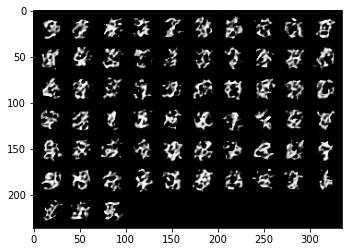

avg_kl_d 2.0399504
is_score 7.690228



avg_kl_d 2.117691
is_score 8.311923



avg_kl_d 2.1038105
is_score 8.197347



avg_kl_d 2.149172
is_score 8.577754



avg_kl_d 2.1653023
is_score 8.717237



avg_kl_d 1.8982975
is_score 6.6745214



avg_kl_d 1.7653412
is_score 5.843565



avg_kl_d 1.8415883
is_score 6.3065467



avg_kl_d 2.0055175
is_score 7.4299374



avg_kl_d 1.7832148
is_score 5.9489503



Epoch: [68] [  50/ 200] D_loss: 1.12459099, G_loss: 0.55156791
Epoch: [68] [ 100/ 200] D_loss: 1.40310442, G_loss: 0.58307958
Epoch: [68] [ 150/ 200] D_loss: 3.74376535, G_loss: 0.61738169
Epoch: [68] [ 200/ 200] D_loss: 3.45712161, G_loss: 0.62845051
Training at Epoch:
67


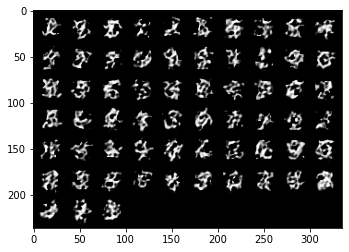

avg_kl_d 1.906615
is_score 6.730268



avg_kl_d 2.0154474
is_score 7.504084



avg_kl_d 2.228043
is_score 9.281685



avg_kl_d 2.0434523
is_score 7.717205



avg_kl_d 1.805459
is_score 6.082763



avg_kl_d 2.0097163
is_score 7.4612



avg_kl_d 1.8517351
is_score 6.3708644



avg_kl_d 1.8158023
is_score 6.1460047



avg_kl_d 2.0051599
is_score 7.4272814



avg_kl_d 1.8469732
is_score 6.3405986



Epoch: [69] [  50/ 200] D_loss: 1.14219809, G_loss: 0.61237466
Epoch: [69] [ 100/ 200] D_loss: 1.17616105, G_loss: 0.61844325
Epoch: [69] [ 150/ 200] D_loss: 4.07673550, G_loss: 0.61526763
Epoch: [69] [ 200/ 200] D_loss: 1.19737673, G_loss: 0.60789871
Training at Epoch:
68


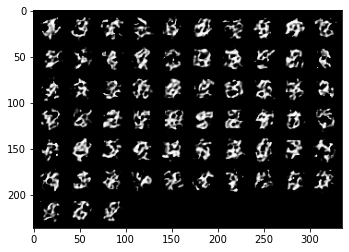

avg_kl_d 2.125688
is_score 8.37866



avg_kl_d 1.7755686
is_score 5.903637



avg_kl_d 1.8733349
is_score 6.50997



avg_kl_d 1.9674574
is_score 7.1524677



avg_kl_d 1.91751
is_score 6.803995



avg_kl_d 1.9359354
is_score 6.9305234



avg_kl_d 2.0265615
is_score 7.5879498



avg_kl_d 1.9934418
is_score 7.340756



avg_kl_d 1.8112371
is_score 6.118011



avg_kl_d 1.942441
is_score 6.975758



Epoch: [70] [  50/ 200] D_loss: 4.66779852, G_loss: 0.55205053
Epoch: [70] [ 100/ 200] D_loss: 1.61315262, G_loss: 0.63801324
Epoch: [70] [ 150/ 200] D_loss: 1.36221457, G_loss: 0.54105979
Epoch: [70] [ 200/ 200] D_loss: 8.09591484, G_loss: 0.61032522
Training at Epoch:
69


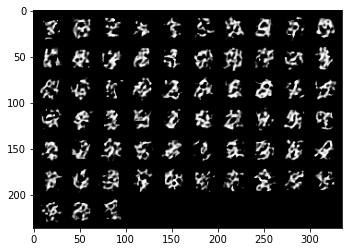

avg_kl_d 2.0624175
is_score 7.8649607



avg_kl_d 1.8839804
is_score 6.5796423



avg_kl_d 1.6929413
is_score 5.435445



avg_kl_d 1.8965876
is_score 6.6631184



avg_kl_d 2.1816075
is_score 8.860538



avg_kl_d 1.8607321
is_score 6.4284406



avg_kl_d 1.9141251
is_score 6.7810035



avg_kl_d 1.8457606
is_score 6.3329144



avg_kl_d 1.8225381
is_score 6.1875434



avg_kl_d 2.039158
is_score 7.684137



Epoch: [71] [  50/ 200] D_loss: 0.99866879, G_loss: 0.61464554
Epoch: [71] [ 100/ 200] D_loss: 6.99312019, G_loss: 0.62536520
Epoch: [71] [ 150/ 200] D_loss: 1.37955701, G_loss: 0.63013393
Epoch: [71] [ 200/ 200] D_loss: 1.19366944, G_loss: 0.64983869
Training at Epoch:
70


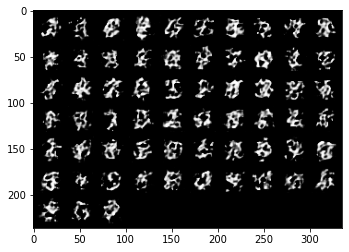

avg_kl_d 2.090907
is_score 8.092253



avg_kl_d 2.1366658
is_score 8.471146



avg_kl_d 2.0094132
is_score 7.4589396



avg_kl_d 1.8667662
is_score 6.4673486



avg_kl_d 2.0342853
is_score 7.6467853



avg_kl_d 1.9814755
is_score 7.253438



avg_kl_d 2.1014285
is_score 8.177843



avg_kl_d 2.082955
is_score 8.028155



avg_kl_d 1.8840212
is_score 6.57991



avg_kl_d 1.9014418
is_score 6.695541



Epoch: [72] [  50/ 200] D_loss: 4.73454905, G_loss: 0.55375743
Epoch: [72] [ 100/ 200] D_loss: 1.56857264, G_loss: 0.61556977
Epoch: [72] [ 150/ 200] D_loss: 1.37902129, G_loss: 0.61289155
Epoch: [72] [ 200/ 200] D_loss: 1.20871556, G_loss: 0.64353395
Training at Epoch:
71


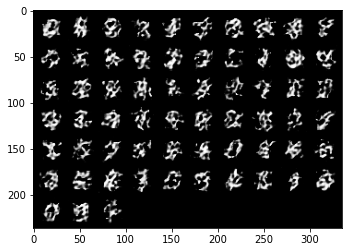

avg_kl_d 1.4516088
is_score 4.2699785



avg_kl_d 2.150689
is_score 8.590775



avg_kl_d 1.9489315
is_score 7.021181



avg_kl_d 1.7974405
is_score 6.034183



avg_kl_d 2.082958
is_score 8.02818



avg_kl_d 1.7174842
is_score 5.5704966



avg_kl_d 1.9966743
is_score 7.364523



avg_kl_d 1.983989
is_score 7.271692



avg_kl_d 2.0628161
is_score 7.8680964



avg_kl_d 2.0197246
is_score 7.536249



Epoch: [73] [  50/ 200] D_loss: 1.07038558, G_loss: 0.60415387
Epoch: [73] [ 100/ 200] D_loss: 1.39722931, G_loss: 0.66876352
Epoch: [73] [ 150/ 200] D_loss: 7.65766668, G_loss: 0.66185653
Epoch: [73] [ 200/ 200] D_loss: 1.60375619, G_loss: 0.69746482
Training at Epoch:
72


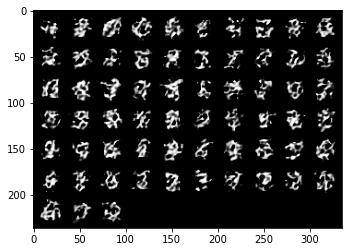

avg_kl_d 1.8793919
is_score 6.5495214



avg_kl_d 2.188894
is_score 8.925337



avg_kl_d 1.7330191
is_score 5.657709



avg_kl_d 2.0214171
is_score 7.5490155



avg_kl_d 2.1296096
is_score 8.411583



avg_kl_d 1.8500593
is_score 6.3601966



avg_kl_d 1.9767306
is_score 7.2191024



avg_kl_d 1.9179409
is_score 6.806927



avg_kl_d 2.049424
is_score 7.7634277



avg_kl_d 1.9575335
is_score 7.081838



Epoch: [74] [  50/ 200] D_loss: 2.06661415, G_loss: 0.65557337
Epoch: [74] [ 100/ 200] D_loss: 0.93950558, G_loss: 0.65414888
Epoch: [74] [ 150/ 200] D_loss: 1.59377909, G_loss: 0.64337146
Epoch: [74] [ 200/ 200] D_loss: 2.01885629, G_loss: 0.64451802
Training at Epoch:
73


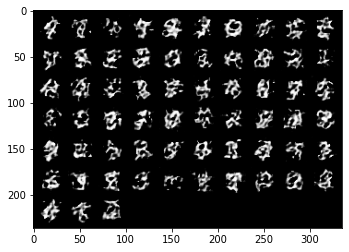

avg_kl_d 2.0355055
is_score 7.6561213



avg_kl_d 1.9620358
is_score 7.1137943



avg_kl_d 2.1462834
is_score 8.553011



avg_kl_d 1.8559043
is_score 6.3974814



avg_kl_d 1.5934724
is_score 4.9208064



avg_kl_d 2.0350356
is_score 7.652525



avg_kl_d 1.7911913
is_score 5.996592



avg_kl_d 1.7831227
is_score 5.9484024



avg_kl_d 1.8151791
is_score 6.1421757



avg_kl_d 1.8658171
is_score 6.4612126



Epoch: [75] [  50/ 200] D_loss: 1.89329290, G_loss: 0.62273669
Epoch: [75] [ 100/ 200] D_loss: 1.35850906, G_loss: 0.62367791
Epoch: [75] [ 150/ 200] D_loss: 1.51109493, G_loss: 0.62531149
Epoch: [75] [ 200/ 200] D_loss: 4.74397469, G_loss: 0.65432972
Training at Epoch:
74


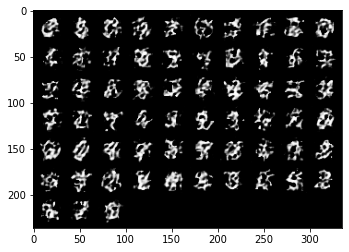

avg_kl_d 2.0042567
is_score 7.420576



avg_kl_d 1.9920588
is_score 7.33061



avg_kl_d 2.0711317
is_score 7.933797



avg_kl_d 2.0601714
is_score 7.847315



avg_kl_d 1.8140106
is_score 6.1350036



avg_kl_d 1.9948902
is_score 7.351396



avg_kl_d 2.0007615
is_score 7.394685



avg_kl_d 1.7893261
is_score 5.985417



avg_kl_d 1.9194691
is_score 6.817338



avg_kl_d 2.1372368
is_score 8.475985



Epoch: [76] [  50/ 200] D_loss: 2.12425375, G_loss: 0.66126418
Epoch: [76] [ 100/ 200] D_loss: 2.14951158, G_loss: 0.61292911
Epoch: [76] [ 150/ 200] D_loss: 1.99067724, G_loss: 0.63416600
Epoch: [76] [ 200/ 200] D_loss: 0.93033367, G_loss: 0.61852586
Training at Epoch:
75


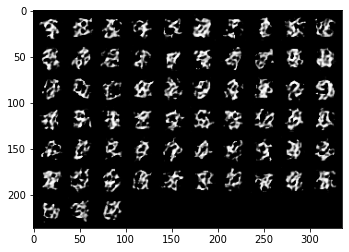

avg_kl_d 2.0959296
is_score 8.1329975



avg_kl_d 2.1176267
is_score 8.311388



avg_kl_d 2.0238066
is_score 7.5670753



avg_kl_d 2.096977
is_score 8.1415205



avg_kl_d 2.2761972
is_score 9.739573



avg_kl_d 1.986412
is_score 7.2893333



avg_kl_d 2.1111228
is_score 8.257508



avg_kl_d 1.9267229
is_score 6.866969



avg_kl_d 1.8986623
is_score 6.676956



avg_kl_d 1.995504
is_score 7.35591



Epoch: [77] [  50/ 200] D_loss: 1.25254154, G_loss: 0.67392159
Epoch: [77] [ 100/ 200] D_loss: 1.16720605, G_loss: 0.66254866
Epoch: [77] [ 150/ 200] D_loss: 1.08142400, G_loss: 0.68321598
Epoch: [77] [ 200/ 200] D_loss: 1.72353280, G_loss: 0.69144303
Training at Epoch:
76


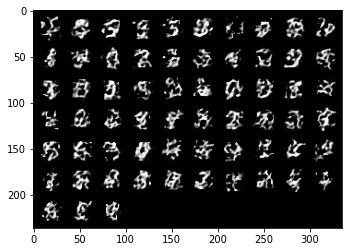

avg_kl_d 2.0413709
is_score 7.701159



avg_kl_d 2.1052232
is_score 8.208935



avg_kl_d 1.9713901
is_score 7.180651



avg_kl_d 2.0440466
is_score 7.721793



avg_kl_d 1.9651127
is_score 7.135717



avg_kl_d 1.8803793
is_score 6.5559907



avg_kl_d 2.0731788
is_score 7.9500546



avg_kl_d 2.1519706
is_score 8.601792



avg_kl_d 1.975791
is_score 7.212322



avg_kl_d 1.778198
is_score 5.9191804



Epoch: [78] [  50/ 200] D_loss: 1.48577464, G_loss: 0.64191771
Epoch: [78] [ 100/ 200] D_loss: 0.98586130, G_loss: 0.64713204
Epoch: [78] [ 150/ 200] D_loss: 1.33399129, G_loss: 0.67788994
Epoch: [78] [ 200/ 200] D_loss: 1.17943072, G_loss: 0.67680162
Training at Epoch:
77


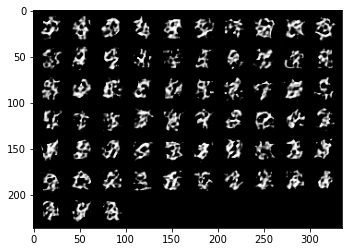

avg_kl_d 2.0325522
is_score 7.633544



avg_kl_d 2.0120208
is_score 7.4784145



avg_kl_d 2.012713
is_score 7.483592



avg_kl_d 1.9276686
is_score 6.8734665



avg_kl_d 1.9299772
is_score 6.8893533



avg_kl_d 1.9376882
is_score 6.9426823



avg_kl_d 1.9971241
is_score 7.367836



avg_kl_d 2.079342
is_score 7.999203



avg_kl_d 1.7552631
is_score 5.784969



avg_kl_d 2.142282
is_score 8.518855



Epoch: [79] [  50/ 200] D_loss: 2.17278528, G_loss: 0.65200108
Epoch: [79] [ 100/ 200] D_loss: 1.54546022, G_loss: 0.65310198
Epoch: [79] [ 150/ 200] D_loss: 1.49338007, G_loss: 0.64746386
Epoch: [79] [ 200/ 200] D_loss: 1.09970152, G_loss: 0.63645232
Training at Epoch:
78


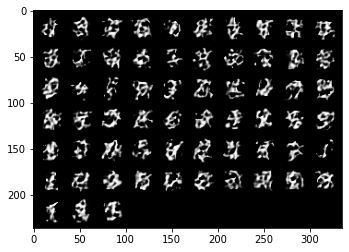

avg_kl_d 1.6533754
is_score 5.224585



avg_kl_d 2.0628614
is_score 7.868453



avg_kl_d 1.9317138
is_score 6.9013276



avg_kl_d 1.957846
is_score 7.084052



avg_kl_d 1.8729528
is_score 6.507484



avg_kl_d 1.9722364
is_score 7.1867304



avg_kl_d 2.15665
is_score 8.6421385



avg_kl_d 1.7742758
is_score 5.8960094



avg_kl_d 1.9213274
is_score 6.830018



avg_kl_d 2.164936
is_score 8.714045



Epoch: [80] [  50/ 200] D_loss: 3.83718872, G_loss: 0.67646140
Epoch: [80] [ 100/ 200] D_loss: 1.86324859, G_loss: 0.72424936
Epoch: [80] [ 150/ 200] D_loss: 3.17773604, G_loss: 0.71467274
Epoch: [80] [ 200/ 200] D_loss: 0.98805976, G_loss: 0.69434273
Training at Epoch:
79


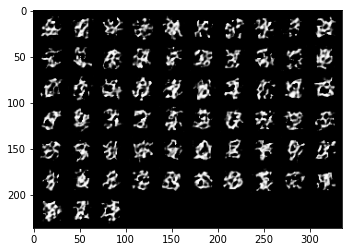

avg_kl_d 2.0284283
is_score 7.602129



avg_kl_d 1.8062553
is_score 6.087609



avg_kl_d 1.7197025
is_score 5.5828676



avg_kl_d 1.8627421
is_score 6.4413757



avg_kl_d 2.1336331
is_score 8.445495



avg_kl_d 2.1477218
is_score 8.565323



avg_kl_d 2.1403394
is_score 8.502322



avg_kl_d 1.9849217
is_score 7.2784777



avg_kl_d 1.9052967
is_score 6.7214017



avg_kl_d 2.0203276
is_score 7.5407944



Epoch: [81] [  50/ 200] D_loss: 1.66649055, G_loss: 0.69570625
Epoch: [81] [ 100/ 200] D_loss: 0.90566856, G_loss: 0.68957686
Epoch: [81] [ 150/ 200] D_loss: 2.98740411, G_loss: 0.71903050
Epoch: [81] [ 200/ 200] D_loss: 1.35971141, G_loss: 0.69995815
Training at Epoch:
80


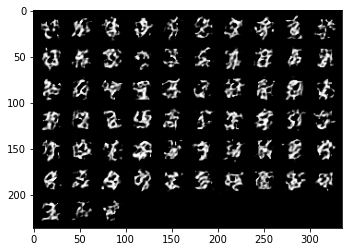

avg_kl_d 2.0554118
is_score 7.810054



avg_kl_d 1.805913
is_score 6.0855246



avg_kl_d 2.0702395
is_score 7.9267216



avg_kl_d 1.9256033
is_score 6.859285



avg_kl_d 1.7631289
is_score 5.8306518



avg_kl_d 1.8310753
is_score 6.240593



avg_kl_d 1.9597222
is_score 7.097355



avg_kl_d 1.9279203
is_score 6.8751974



avg_kl_d 2.1321507
is_score 8.432983



avg_kl_d 2.1951375
is_score 8.981236



Epoch: [82] [  50/ 200] D_loss: 1.23377573, G_loss: 0.70439255
Epoch: [82] [ 100/ 200] D_loss: 1.07077003, G_loss: 0.67380387
Epoch: [82] [ 150/ 200] D_loss: 1.56188738, G_loss: 0.74032903
Epoch: [82] [ 200/ 200] D_loss: 2.13093615, G_loss: 0.70327371
Training at Epoch:
81


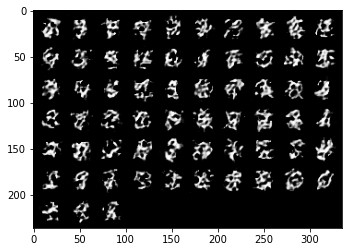

avg_kl_d 2.08694
is_score 8.060213



avg_kl_d 2.0076084
is_score 7.4454894



avg_kl_d 1.9383447
is_score 6.9472413



avg_kl_d 1.9315498
is_score 6.9001956



avg_kl_d 1.9931933
is_score 7.338932



avg_kl_d 1.8730009
is_score 6.5077963



avg_kl_d 1.970743
is_score 7.176006



avg_kl_d 1.857061
is_score 6.4048853



avg_kl_d 2.0806007
is_score 8.009279



avg_kl_d 2.1629052
is_score 8.696365



Epoch: [83] [  50/ 200] D_loss: 1.54386973, G_loss: 0.64256746
Epoch: [83] [ 100/ 200] D_loss: 1.06441045, G_loss: 0.65484977
Epoch: [83] [ 150/ 200] D_loss: 3.26086998, G_loss: 0.69761956
Epoch: [83] [ 200/ 200] D_loss: 3.80930805, G_loss: 0.69481534
Training at Epoch:
82


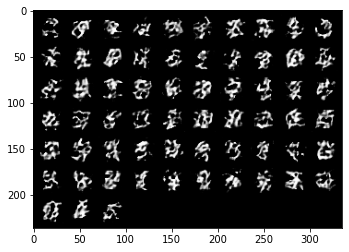

avg_kl_d 1.9321486
is_score 6.904329



avg_kl_d 1.874692
is_score 6.5188107



avg_kl_d 1.8776773
is_score 6.5383005



avg_kl_d 1.9658941
is_score 7.1412954



avg_kl_d 2.054707
is_score 7.804551



avg_kl_d 1.9383568
is_score 6.9473248



avg_kl_d 1.8646994
is_score 6.453995



avg_kl_d 1.8577087
is_score 6.4090347



avg_kl_d 2.1053083
is_score 8.209634



avg_kl_d 2.1069922
is_score 8.22347



Epoch: [84] [  50/ 200] D_loss: 1.86663651, G_loss: 0.74834895
Epoch: [84] [ 100/ 200] D_loss: 1.32908785, G_loss: 0.71671003
Epoch: [84] [ 150/ 200] D_loss: 2.69307041, G_loss: 0.72615778
Epoch: [84] [ 200/ 200] D_loss: 1.24856389, G_loss: 0.71915525
Training at Epoch:
83


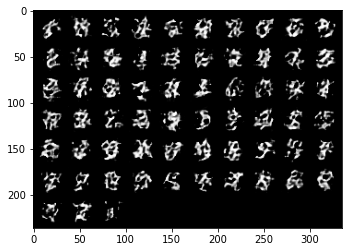

avg_kl_d 1.9380811
is_score 6.9454107



avg_kl_d 2.0873873
is_score 8.063819



avg_kl_d 2.1493952
is_score 8.579668



avg_kl_d 2.0179832
is_score 7.523137



avg_kl_d 2.089304
is_score 8.079289



avg_kl_d 1.8586953
is_score 6.4153614



avg_kl_d 2.0023472
is_score 7.4064207



avg_kl_d 2.0308316
is_score 7.620421



avg_kl_d 2.113271
is_score 8.275266



avg_kl_d 1.9584644
is_score 7.0884333



Epoch: [85] [  50/ 200] D_loss: 1.92018390, G_loss: 0.70495403
Epoch: [85] [ 100/ 200] D_loss: 6.17209768, G_loss: 0.70065343
Epoch: [85] [ 150/ 200] D_loss: 6.98622322, G_loss: 0.69943523
Epoch: [85] [ 200/ 200] D_loss: 1.14207053, G_loss: 0.71521103
Training at Epoch:
84


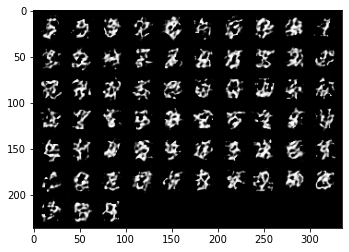

avg_kl_d 1.8956035
is_score 6.6565647



avg_kl_d 2.003436
is_score 7.4144897



avg_kl_d 2.0691612
is_score 7.9181786



avg_kl_d 1.9230261
is_score 6.8416305



avg_kl_d 2.0495968
is_score 7.76477



avg_kl_d 2.0923457
is_score 8.103902



avg_kl_d 2.1269138
is_score 8.388937



avg_kl_d 1.9912075
is_score 7.324373



avg_kl_d 1.9499209
is_score 7.0281315



avg_kl_d 1.9590555
is_score 7.092625



Epoch: [86] [  50/ 200] D_loss: 2.35433364, G_loss: 0.71288669
Epoch: [86] [ 100/ 200] D_loss: 1.08385193, G_loss: 0.72832733
Epoch: [86] [ 150/ 200] D_loss: 1.12065351, G_loss: 0.74641836
Epoch: [86] [ 200/ 200] D_loss: 0.93098253, G_loss: 0.70055991
Training at Epoch:
85


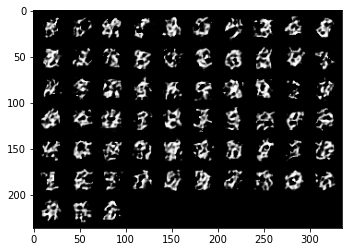

avg_kl_d 2.126884
is_score 8.388686



avg_kl_d 1.9268395
is_score 6.86777



avg_kl_d 1.760932
is_score 5.817857



avg_kl_d 2.0445094
is_score 7.7253675



avg_kl_d 2.1723564
is_score 8.778947



avg_kl_d 1.9584341
is_score 7.0882187



avg_kl_d 2.070517
is_score 7.928921



avg_kl_d 1.9670494
is_score 7.149549



avg_kl_d 1.957367
is_score 7.0806584



avg_kl_d 2.1047754
is_score 8.20526



Epoch: [87] [  50/ 200] D_loss: 1.30717087, G_loss: 0.73693943
Epoch: [87] [ 100/ 200] D_loss: 3.59624386, G_loss: 0.73249346
Epoch: [87] [ 150/ 200] D_loss: 1.06419849, G_loss: 0.69750547
Epoch: [87] [ 200/ 200] D_loss: 1.18566227, G_loss: 0.74424654
Training at Epoch:
86


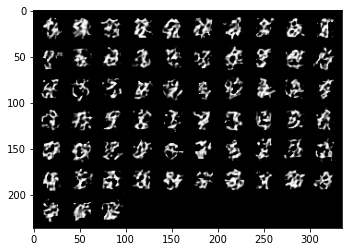

avg_kl_d 2.1907012
is_score 8.941482



avg_kl_d 1.9865624
is_score 7.290429



avg_kl_d 2.0607824
is_score 7.8521113



avg_kl_d 1.9957201
is_score 7.3574996



avg_kl_d 1.9583414
is_score 7.087562



avg_kl_d 1.6377633
is_score 5.1436515



avg_kl_d 1.9064785
is_score 6.7293496



avg_kl_d 2.0814893
is_score 8.016399



avg_kl_d 2.01833
is_score 7.525747



avg_kl_d 1.9203821
is_score 6.823566



Epoch: [88] [  50/ 200] D_loss: 3.09467554, G_loss: 0.76690429
Epoch: [88] [ 100/ 200] D_loss: 0.96298730, G_loss: 0.74135607
Epoch: [88] [ 150/ 200] D_loss: 0.95987839, G_loss: 0.76085448
Epoch: [88] [ 200/ 200] D_loss: 1.20763290, G_loss: 0.71242499
Training at Epoch:
87


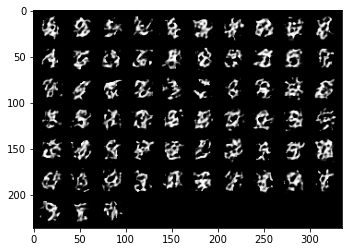

avg_kl_d 1.9733965
is_score 7.195073



avg_kl_d 2.2023346
is_score 9.046108



avg_kl_d 1.8833325
is_score 6.5753803



avg_kl_d 2.1273317
is_score 8.392444



avg_kl_d 1.9392166
is_score 6.9533014



avg_kl_d 2.022467
is_score 7.556944



avg_kl_d 1.8873914
is_score 6.6021237



avg_kl_d 2.021299
is_score 7.5481224



avg_kl_d 1.7283373
is_score 5.6312833



avg_kl_d 1.902367
is_score 6.701739



Epoch: [89] [  50/ 200] D_loss: 1.07379162, G_loss: 0.67462486
Epoch: [89] [ 100/ 200] D_loss: 0.94745868, G_loss: 0.72416538
Epoch: [89] [ 150/ 200] D_loss: 6.28116894, G_loss: 0.76089036
Epoch: [89] [ 200/ 200] D_loss: 1.41617727, G_loss: 0.76135582
Training at Epoch:
88


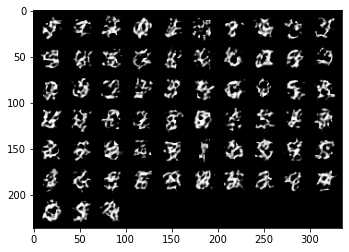

avg_kl_d 2.03363
is_score 7.6417747



avg_kl_d 1.8937327
is_score 6.6441226



avg_kl_d 1.8900776
is_score 6.619882



avg_kl_d 1.6583465
is_score 5.2506223



avg_kl_d 2.015937
is_score 7.5077596



avg_kl_d 1.9928763
is_score 7.336606



avg_kl_d 2.036172
is_score 7.6612253



avg_kl_d 1.9967368
is_score 7.3649836



avg_kl_d 1.959027
is_score 7.092423



avg_kl_d 2.0341709
is_score 7.64591



Epoch: [90] [  50/ 200] D_loss: 5.43992138, G_loss: 0.69904923
Epoch: [90] [ 100/ 200] D_loss: 0.94433928, G_loss: 0.71942121
Epoch: [90] [ 150/ 200] D_loss: 1.41829228, G_loss: 0.69762307
Epoch: [90] [ 200/ 200] D_loss: 1.11623454, G_loss: 0.76682031
Training at Epoch:
89


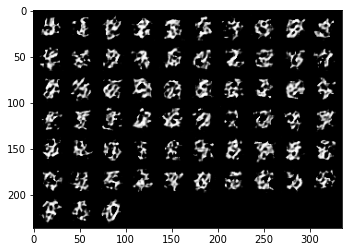

avg_kl_d 1.9834286
is_score 7.2676177



avg_kl_d 1.9870265
is_score 7.293813



avg_kl_d 1.7772955
is_score 5.9138403



avg_kl_d 1.9182203
is_score 6.80883



avg_kl_d 2.01571
is_score 7.5060554



avg_kl_d 1.8929214
is_score 6.6387353



avg_kl_d 2.049475
is_score 7.7638235



avg_kl_d 2.0738
is_score 7.954995



avg_kl_d 2.0380588
is_score 7.6756945



avg_kl_d 1.9307566
is_score 6.894725



Epoch: [91] [  50/ 200] D_loss: 4.29173279, G_loss: 0.70923066
Epoch: [91] [ 100/ 200] D_loss: 2.89581823, G_loss: 0.72900409
Epoch: [91] [ 150/ 200] D_loss: 1.21437931, G_loss: 0.75256157
Epoch: [91] [ 200/ 200] D_loss: 1.83693588, G_loss: 0.67109233
Training at Epoch:
90


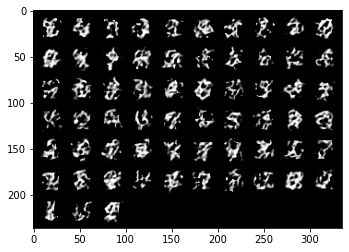

avg_kl_d 2.0195408
is_score 7.534864



avg_kl_d 1.9614229
is_score 7.109436



avg_kl_d 1.8088992
is_score 6.1037245



avg_kl_d 1.8486729
is_score 6.351385



avg_kl_d 1.8787668
is_score 6.545428



avg_kl_d 2.018979
is_score 7.5306334



avg_kl_d 2.1183374
is_score 8.317298



avg_kl_d 1.9666622
is_score 7.146782



avg_kl_d 2.0898387
is_score 8.0836115



avg_kl_d 1.9900614
is_score 7.3159823



Epoch: [92] [  50/ 200] D_loss: 1.10674882, G_loss: 0.79199648
Epoch: [92] [ 100/ 200] D_loss: 1.93553126, G_loss: 0.75474536
Epoch: [92] [ 150/ 200] D_loss: 6.55119371, G_loss: 0.74924904
Epoch: [92] [ 200/ 200] D_loss: 2.44658279, G_loss: 0.68570918
Training at Epoch:
91


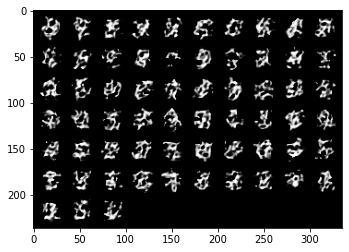

avg_kl_d 2.076367
is_score 7.97544



avg_kl_d 1.852986
is_score 6.378838



avg_kl_d 2.0323951
is_score 7.632345



avg_kl_d 2.0174196
is_score 7.5188975



avg_kl_d 2.0080543
is_score 7.44881



avg_kl_d 2.0329132
is_score 7.6363



avg_kl_d 2.1445756
is_score 8.538417



avg_kl_d 2.0031734
is_score 7.4125414



avg_kl_d 2.0665536
is_score 7.8975577



avg_kl_d 2.060186
is_score 7.847428



Epoch: [93] [  50/ 200] D_loss: 0.91989446, G_loss: 0.72573721
Epoch: [93] [ 100/ 200] D_loss: 0.90815216, G_loss: 0.73068726
Epoch: [93] [ 150/ 200] D_loss: 0.92574048, G_loss: 0.77958548
Epoch: [93] [ 200/ 200] D_loss: 2.02163506, G_loss: 0.74578184
Training at Epoch:
92


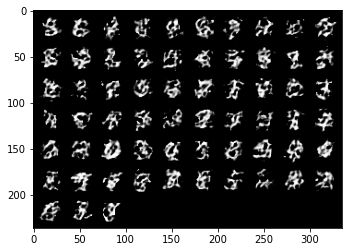

avg_kl_d 2.0733092
is_score 7.9510913



avg_kl_d 1.9844185
is_score 7.274816



avg_kl_d 1.9789836
is_score 7.2353854



avg_kl_d 1.9674644
is_score 7.1525173



avg_kl_d 1.9404285
is_score 6.961733



avg_kl_d 1.9929173
is_score 7.3369064



avg_kl_d 1.998225
is_score 7.375952



avg_kl_d 1.7781357
is_score 5.9188113



avg_kl_d 2.02108
is_score 7.5464706



avg_kl_d 2.1621146
is_score 8.689493



Epoch: [94] [  50/ 200] D_loss: 1.65445220, G_loss: 0.75269902
Epoch: [94] [ 100/ 200] D_loss: 1.12103939, G_loss: 0.77079713
Epoch: [94] [ 150/ 200] D_loss: 2.69237304, G_loss: 0.73475266
Epoch: [94] [ 200/ 200] D_loss: 2.22338986, G_loss: 0.74233836
Training at Epoch:
93


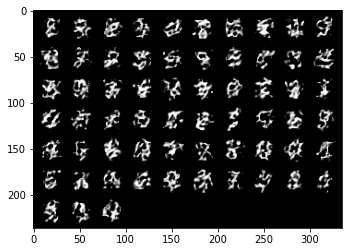

avg_kl_d 2.0529733
is_score 7.7910314



avg_kl_d 2.1175113
is_score 8.31043



avg_kl_d 2.0372293
is_score 7.6693306



avg_kl_d 2.0168223
is_score 7.5144086



avg_kl_d 1.7328775
is_score 5.6569076



avg_kl_d 1.8824657
is_score 6.569684



avg_kl_d 1.9167019
is_score 6.798499



avg_kl_d 2.044102
is_score 7.72222



avg_kl_d 1.670969
is_score 5.317318



avg_kl_d 1.8105762
is_score 6.1139693



Epoch: [95] [  50/ 200] D_loss: 1.41001618, G_loss: 0.71710396
Epoch: [95] [ 100/ 200] D_loss: 1.95435691, G_loss: 0.79245830
Epoch: [95] [ 150/ 200] D_loss: 1.85067940, G_loss: 0.69260764
Epoch: [95] [ 200/ 200] D_loss: 0.88824672, G_loss: 0.73189259
Training at Epoch:
94


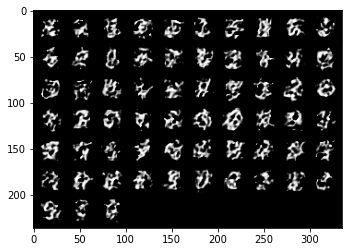

avg_kl_d 1.7827046
is_score 5.9459157



avg_kl_d 2.0054202
is_score 7.429215



avg_kl_d 1.9759133
is_score 7.2132044



avg_kl_d 1.9702991
is_score 7.172822



avg_kl_d 1.9713504
is_score 7.1803665



avg_kl_d 2.0103927
is_score 7.466249



avg_kl_d 2.0204968
is_score 7.5420713



avg_kl_d 2.140389
is_score 8.502745



avg_kl_d 2.1279197
is_score 8.397379



avg_kl_d 1.993953
is_score 7.344509



Epoch: [96] [  50/ 200] D_loss: 4.16815567, G_loss: 0.78565311
Epoch: [96] [ 100/ 200] D_loss: 1.13262427, G_loss: 0.76406121
Epoch: [96] [ 150/ 200] D_loss: 0.96036351, G_loss: 0.70878255
Epoch: [96] [ 200/ 200] D_loss: 0.97232503, G_loss: 0.74418479
Training at Epoch:
95


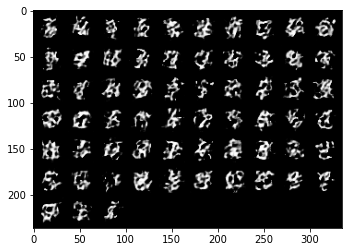

avg_kl_d 1.8550625
is_score 6.392098



avg_kl_d 2.119809
is_score 8.329546



avg_kl_d 1.8895515
is_score 6.6164007



avg_kl_d 1.9063046
is_score 6.7281795



avg_kl_d 1.9661906
is_score 7.1434126



avg_kl_d 2.0292041
is_score 7.6080294



avg_kl_d 2.0453172
is_score 7.7316103



avg_kl_d 1.8486767
is_score 6.351409



avg_kl_d 1.9993061
is_score 7.3839307



avg_kl_d 2.0675817
is_score 7.9056816



Epoch: [97] [  50/ 200] D_loss: 3.30375504, G_loss: 0.74123120
Epoch: [97] [ 100/ 200] D_loss: 2.52046943, G_loss: 0.74338353
Epoch: [97] [ 150/ 200] D_loss: 1.11222327, G_loss: 0.73659289
Epoch: [97] [ 200/ 200] D_loss: 0.86970979, G_loss: 0.75248110
Training at Epoch:
96


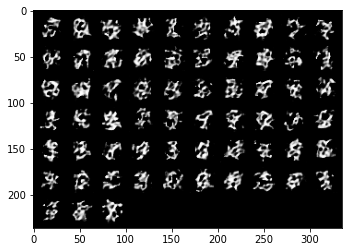

avg_kl_d 1.9901226
is_score 7.3164306



avg_kl_d 1.9441013
is_score 6.9873495



avg_kl_d 2.0325022
is_score 7.633162



avg_kl_d 2.0583081
is_score 7.832707



avg_kl_d 2.0518107
is_score 7.7819796



avg_kl_d 1.9742899
is_score 7.2015038



avg_kl_d 1.8088524
is_score 6.103439



avg_kl_d 1.9695942
is_score 7.167767



avg_kl_d 1.9501079
is_score 7.029446



avg_kl_d 2.0800643
is_score 8.004983



Epoch: [98] [  50/ 200] D_loss: 1.31654239, G_loss: 0.76525873
Epoch: [98] [ 100/ 200] D_loss: 1.25155759, G_loss: 0.77246952
Epoch: [98] [ 150/ 200] D_loss: 1.73517966, G_loss: 0.80311185
Epoch: [98] [ 200/ 200] D_loss: 1.00169194, G_loss: 0.73743272
Training at Epoch:
97


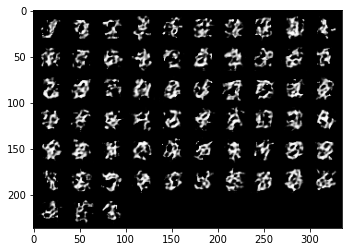

avg_kl_d 2.0220764
is_score 7.5539937



avg_kl_d 2.1234891
is_score 8.360257



avg_kl_d 2.0268617
is_score 7.590228



avg_kl_d 2.1136909
is_score 8.278741



avg_kl_d 2.107523
is_score 8.227835



avg_kl_d 1.9688933
is_score 7.1627455



avg_kl_d 2.1021585
is_score 8.183816



avg_kl_d 2.1009734
is_score 8.174123



avg_kl_d 1.9032412
is_score 6.7075996



avg_kl_d 1.6417735
is_score 5.16432



Epoch: [99] [  50/ 200] D_loss: 1.86969137, G_loss: 0.76717937
Epoch: [99] [ 100/ 200] D_loss: 1.15610552, G_loss: 0.72972190
Epoch: [99] [ 150/ 200] D_loss: 2.17217207, G_loss: 0.79411185
Epoch: [99] [ 200/ 200] D_loss: 0.87272674, G_loss: 0.73431176
Training at Epoch:
98


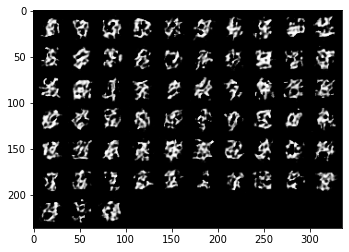

avg_kl_d 2.010075
is_score 7.4638777



avg_kl_d 2.0863318
is_score 8.055313



avg_kl_d 1.9757274
is_score 7.2118645



avg_kl_d 2.1272395
is_score 8.39167



avg_kl_d 2.039968
is_score 7.690363



avg_kl_d 2.039615
is_score 7.6876483



avg_kl_d 2.0536885
is_score 7.7966065



avg_kl_d 2.025507
is_score 7.5799527



avg_kl_d 1.9105778
is_score 6.756992



avg_kl_d 1.928133
is_score 6.87666



Epoch: [100] [  50/ 200] D_loss: 1.00900960, G_loss: 0.78253216
Epoch: [100] [ 100/ 200] D_loss: 1.89991879, G_loss: 0.79240233
Epoch: [100] [ 150/ 200] D_loss: 0.91614336, G_loss: 0.80355072
Epoch: [100] [ 200/ 200] D_loss: 1.36408114, G_loss: 0.73799467
Training at Epoch:
99


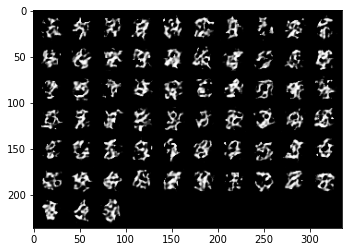

avg_kl_d 2.055421
is_score 7.8101263



avg_kl_d 1.909817
is_score 6.751853



avg_kl_d 2.0497732
is_score 7.7661395



avg_kl_d 1.9081202
is_score 6.740406



avg_kl_d 2.0867145
is_score 8.058396



avg_kl_d 2.0009131
is_score 7.3958063



avg_kl_d 2.0071845
is_score 7.4423337



avg_kl_d 1.8334172
is_score 6.255225



avg_kl_d 1.870562
is_score 6.4919434



avg_kl_d 2.009832
is_score 7.4620633



Training finished!


In [15]:
params = {'beta1': 0.5, 'beta2': 0.9,'lr_g':0.002,'lr_d':0.002,'max_epochs':100}

params['z_dim'] = 100
params['base_size'] = 64

gan = GAN(params)


gan.train()

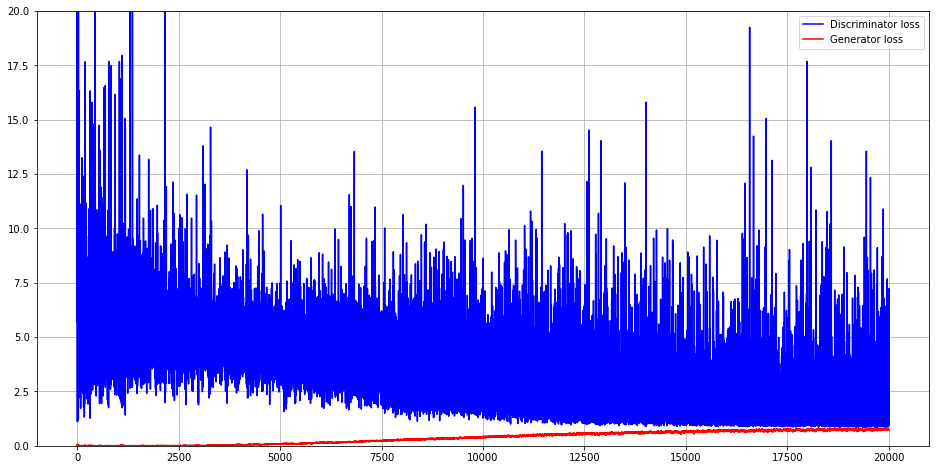

In [20]:

plt.figure(figsize=(16,8))
s=plt.plot(gan.train_hist['D_loss'],c='b')
s=plt.plot(gan.train_hist['G_loss'],c='r')
s = plt.ylim((0,20))
s = plt.grid()
s=plt.legend(('Discriminator loss','Generator loss'))

# plotting inception Score for model with latent dim =100


[7.3513575, 7.3200784, 7.4841814, 7.5940537, 7.10559, 7.924044, 7.5516686, 7.259332, 7.4566026, 7.50207, 6.4794974, 7.5205183, 7.3117304, 7.2283106, 7.0827036, 7.106866, 7.4491677, 7.455208, 7.179324, 7.3229027, 7.4015284, 7.0675673, 7.115344, 7.004037, 7.024905, 7.0837946, 7.136603, 7.581637, 7.2833443, 6.7819, 7.2601614, 7.019262, 7.291562, 7.028534, 7.8060656, 7.6722054, 7.4357147, 7.4632044, 7.0593276, 7.622659, 7.3983474, 7.6537375, 7.2665787, 7.348979, 7.013124, 7.1842585, 6.8822694, 7.4404764, 7.572254, 7.908998, 7.361909, 6.826953, 7.1299276, 7.3595304, 7.1986084, 7.903884, 7.620738, 7.5773115, 7.5441275, 7.163265, 7.0018797, 7.468689, 7.1121, 7.4608145, 7.4680314, 7.1974525, 7.3698015, 7.106196, 6.970173, 6.881774, 7.487136, 6.955535, 7.232466, 6.6842127, 7.2692122, 7.8339233, 7.41876, 7.2971907, 7.0854845, 7.27678, 7.21396, 7.3486404, 7.115075, 7.599723, 7.4533606, 7.5031233, 7.276779, 7.2202516, 7.0765314, 7.1718125, 7.2039146, 7.6286573, 7.3443174, 6.9463797, 7.4194474, 7.2

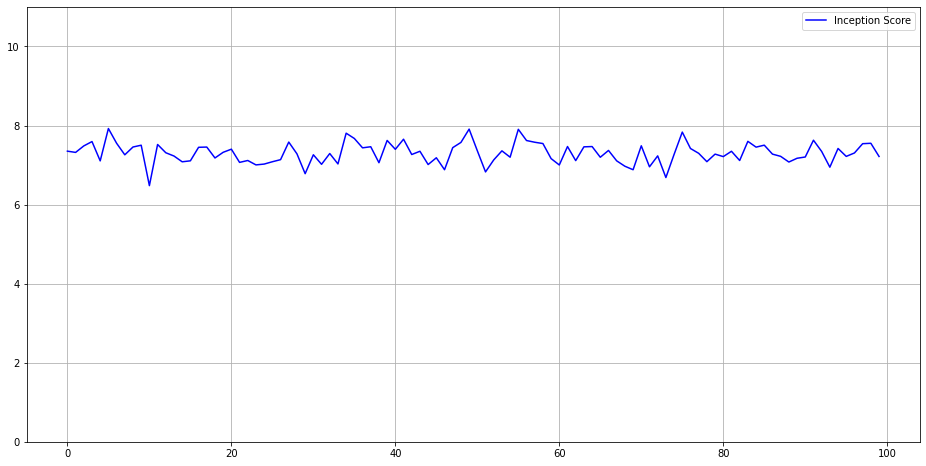

In [17]:

plt.figure(figsize=(16,8))
s=plt.plot(gan.train_hist['IS_score'],c='b')
s = plt.ylim((0,11))
s = plt.grid()
s=plt.legend(('Inception Score','Generator loss'))
print(gan.train_hist['IS_score'])

# model with latent dim 10

1
training start!!
Epoch: [ 1] [  50/ 200] D_loss: 8.64731789, G_loss: 0.00857484
Epoch: [ 1] [ 100/ 200] D_loss: 4.89157295, G_loss: 0.00039119
Epoch: [ 1] [ 150/ 200] D_loss: 5.27208042, G_loss: 0.00031644
Epoch: [ 1] [ 200/ 200] D_loss: 6.74508142, G_loss: 0.00147778
Training at Epoch:
0


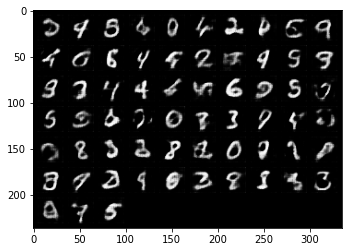

is_score 6.269



is_score 5.630236



is_score 6.085306



is_score 6.483461



is_score 5.536194



is_score 6.3251147



is_score 5.8424735



is_score 4.779943



is_score 4.9241



is_score 5.390148



Epoch: [ 2] [  50/ 200] D_loss: 3.05474710, G_loss: 0.00325292
Epoch: [ 2] [ 100/ 200] D_loss: 5.26945543, G_loss: 0.00051057
Epoch: [ 2] [ 150/ 200] D_loss: 5.68606377, G_loss: 0.00474524
Epoch: [ 2] [ 200/ 200] D_loss: 6.52041435, G_loss: 0.01373011
Epoch: [ 3] [  50/ 200] D_loss: 4.45051289, G_loss: 0.00000638
Epoch: [ 3] [ 100/ 200] D_loss: 5.57364225, G_loss: 0.00036430
Epoch: [ 3] [ 150/ 200] D_loss: 16.54135323, G_loss: 0.01932114
Epoch: [ 3] [ 200/ 200] D_loss: 5.62182236, G_loss: 0.00013345
Epoch: [ 4] [  50/ 200] D_loss: 4.33048248, G_loss: 0.00557613
Epoch: [ 4] [ 100/ 200] D_loss: 3.45420885, G_loss: 0.00308228
Epoch: [ 4] [ 150/ 200] D_loss: 7.89076662, G_loss: 0.00203377
Epoch: [ 4] [ 200/ 200] D_loss: 6.60580826, G_loss: 0.00335735
Epoch: [ 5] [  50/ 200] D_loss: 3.94

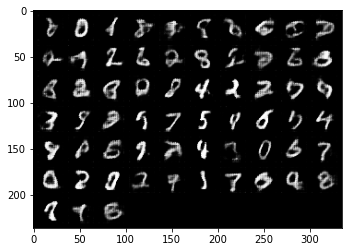

is_score 5.9202237



is_score 5.6598134



is_score 6.37622



is_score 5.201059



is_score 6.909362



is_score 4.542541



is_score 6.0651684



is_score 6.471991



is_score 6.0501256



is_score 4.7109



Epoch: [12] [  50/ 200] D_loss: 4.73975086, G_loss: 0.00921500
Epoch: [12] [ 100/ 200] D_loss: 4.12427425, G_loss: 0.02048463
Epoch: [12] [ 150/ 200] D_loss: 3.88920879, G_loss: 0.02598143
Epoch: [12] [ 200/ 200] D_loss: 8.70987320, G_loss: 0.02841169
Epoch: [13] [  50/ 200] D_loss: 5.03809404, G_loss: 0.01175028
Epoch: [13] [ 100/ 200] D_loss: 3.72191811, G_loss: 0.01901954
Epoch: [13] [ 150/ 200] D_loss: 5.69168377, G_loss: 0.02264047
Epoch: [13] [ 200/ 200] D_loss: 5.90888309, G_loss: 0.03057778
Epoch: [14] [  50/ 200] D_loss: 4.84774590, G_loss: 0.04010731
Epoch: [14] [ 100/ 200] D_loss: 4.91285849, G_loss: 0.04996216
Epoch: [14] [ 150/ 200] D_loss: 4.09804916, G_loss: 0.04460806
Epoch: [14] [ 200/ 200] D_loss: 5.18253231, G_loss: 0.04688632
Epoch: [15] [  50/ 200] D_loss: 3

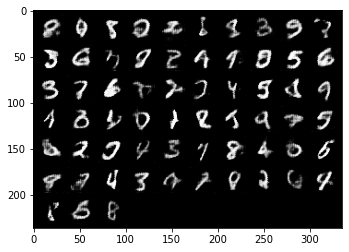

is_score 5.415228



is_score 6.3979325



is_score 5.8942857



is_score 4.998159



is_score 6.9045916



is_score 5.6372676



is_score 5.8894134



is_score 4.7349377



is_score 5.5018992



is_score 5.448154



Epoch: [22] [  50/ 200] D_loss: 5.29980612, G_loss: 0.12398845
Epoch: [22] [ 100/ 200] D_loss: 6.38993168, G_loss: 0.10571468
Epoch: [22] [ 150/ 200] D_loss: 3.89590168, G_loss: 0.12569350
Epoch: [22] [ 200/ 200] D_loss: 2.58073354, G_loss: 0.09623474
Epoch: [23] [  50/ 200] D_loss: 3.17693758, G_loss: 0.11432147
Epoch: [23] [ 100/ 200] D_loss: 2.59014463, G_loss: 0.12467331
Epoch: [23] [ 150/ 200] D_loss: 3.91868591, G_loss: 0.12417483
Epoch: [23] [ 200/ 200] D_loss: 4.03830099, G_loss: 0.13871211
Epoch: [24] [  50/ 200] D_loss: 2.75393319, G_loss: 0.13125044
Epoch: [24] [ 100/ 200] D_loss: 4.50547314, G_loss: 0.12132263
Epoch: [24] [ 150/ 200] D_loss: 4.75302362, G_loss: 0.15693349
Epoch: [24] [ 200/ 200] D_loss: 3.54349399, G_loss: 0.17725956
Epoch: [25] [  50/ 200] D_l

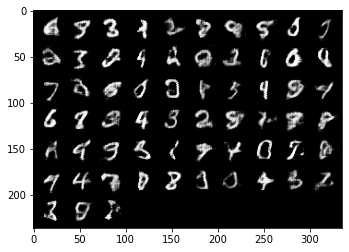

is_score 6.2467966



is_score 6.4759803



is_score 5.456226



is_score 5.691292



is_score 5.923859



is_score 5.5827546



is_score 5.0476217



is_score 6.120119



is_score 5.4980273



is_score 6.8612523



Epoch: [32] [  50/ 200] D_loss: 4.43405294, G_loss: 0.28835678
Epoch: [32] [ 100/ 200] D_loss: 2.20278144, G_loss: 0.22180653
Epoch: [32] [ 150/ 200] D_loss: 5.19593430, G_loss: 0.25683445
Epoch: [32] [ 200/ 200] D_loss: 4.94399977, G_loss: 0.26817620
Epoch: [33] [  50/ 200] D_loss: 2.42767000, G_loss: 0.24237192
Epoch: [33] [ 100/ 200] D_loss: 3.49044704, G_loss: 0.26173794
Epoch: [33] [ 150/ 200] D_loss: 5.49911070, G_loss: 0.23965141
Epoch: [33] [ 200/ 200] D_loss: 4.21925688, G_loss: 0.31823111
Epoch: [34] [  50/ 200] D_loss: 5.39568949, G_loss: 0.25084215
Epoch: [34] [ 100/ 200] D_loss: 5.41113281, G_loss: 0.27832282
Epoch: [34] [ 150/ 200] D_loss: 4.29990101, G_loss: 0.22104353
Epoch: [34] [ 200/ 200] D_loss: 3.54401922, G_loss: 0.26668787
Epoch: [35] [  50/ 200] D_lo

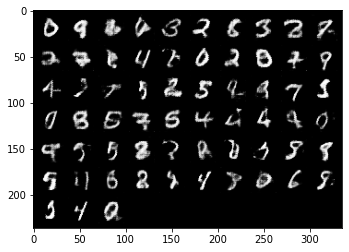

is_score 3.9177396



is_score 4.5190625



is_score 5.131457



is_score 5.5279865



is_score 6.170079



is_score 5.5685396



is_score 4.4313116



is_score 5.4952984



is_score 6.0011973



is_score 5.9226475



Epoch: [42] [  50/ 200] D_loss: 13.89215183, G_loss: 0.42218247
Epoch: [42] [ 100/ 200] D_loss: 2.23284340, G_loss: 0.42257246
Epoch: [42] [ 150/ 200] D_loss: 2.86384964, G_loss: 0.36975780
Epoch: [42] [ 200/ 200] D_loss: 3.14453411, G_loss: 0.37579879
Epoch: [43] [  50/ 200] D_loss: 1.27345657, G_loss: 0.36045578
Epoch: [43] [ 100/ 200] D_loss: 2.06508136, G_loss: 0.43238023
Epoch: [43] [ 150/ 200] D_loss: 2.37053013, G_loss: 0.40503651
Epoch: [43] [ 200/ 200] D_loss: 4.90369368, G_loss: 0.44525400
Epoch: [44] [  50/ 200] D_loss: 5.22116280, G_loss: 0.37563476
Epoch: [44] [ 100/ 200] D_loss: 2.85715199, G_loss: 0.40518555
Epoch: [44] [ 150/ 200] D_loss: 2.67133760, G_loss: 0.39611059
Epoch: [44] [ 200/ 200] D_loss: 5.50105619, G_loss: 0.41502374
Epoch: [45] [  50/ 200] D

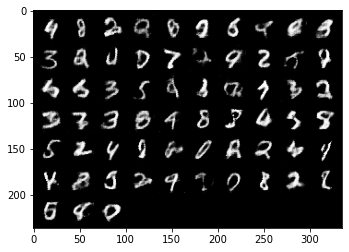

is_score 5.507284



is_score 6.2769084



is_score 7.4489055



is_score 7.3593736



is_score 5.8870387



is_score 6.717069



is_score 5.606042



is_score 6.6170053



is_score 6.2312837



is_score 5.1448097



Epoch: [52] [  50/ 200] D_loss: 1.99921417, G_loss: 0.58609295
Epoch: [52] [ 100/ 200] D_loss: 1.63032365, G_loss: 0.53409493
Epoch: [52] [ 150/ 200] D_loss: 1.61316276, G_loss: 0.50880063
Epoch: [52] [ 200/ 200] D_loss: 2.53811502, G_loss: 0.46183741
Epoch: [53] [  50/ 200] D_loss: 2.53686714, G_loss: 0.54977334
Epoch: [53] [ 100/ 200] D_loss: 1.27546787, G_loss: 0.54104769
Epoch: [53] [ 150/ 200] D_loss: 4.32702303, G_loss: 0.46159261
Epoch: [53] [ 200/ 200] D_loss: 3.68378496, G_loss: 0.51934981
Epoch: [54] [  50/ 200] D_loss: 2.99542356, G_loss: 0.52819848
Epoch: [54] [ 100/ 200] D_loss: 9.77824211, G_loss: 0.53467220
Epoch: [54] [ 150/ 200] D_loss: 2.48587084, G_loss: 0.51969045
Epoch: [54] [ 200/ 200] D_loss: 1.59105659, G_loss: 0.57138872
Epoch: [55] [  50/ 200] D_l

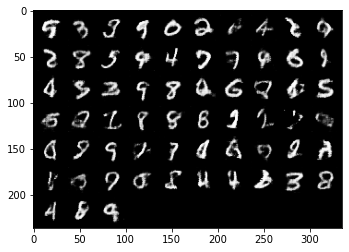

is_score 6.702648



is_score 6.7710133



is_score 6.5292335



is_score 6.1875386



is_score 7.4979563



is_score 5.283409



is_score 6.473942



is_score 5.634809



is_score 4.201981



is_score 5.272359



Epoch: [62] [  50/ 200] D_loss: 1.22147417, G_loss: 0.60362422
Epoch: [62] [ 100/ 200] D_loss: 2.04313707, G_loss: 0.58974040
Epoch: [62] [ 150/ 200] D_loss: 1.78481126, G_loss: 0.58860505
Epoch: [62] [ 200/ 200] D_loss: 1.33539200, G_loss: 0.59180856
Epoch: [63] [  50/ 200] D_loss: 1.43404341, G_loss: 0.47287700
Epoch: [63] [ 100/ 200] D_loss: 2.53430033, G_loss: 0.61335230
Epoch: [63] [ 150/ 200] D_loss: 3.25886512, G_loss: 0.61785883
Epoch: [63] [ 200/ 200] D_loss: 1.31414270, G_loss: 0.61161363
Epoch: [64] [  50/ 200] D_loss: 1.12216222, G_loss: 0.58768010
Epoch: [64] [ 100/ 200] D_loss: 2.85771418, G_loss: 0.52284938
Epoch: [64] [ 150/ 200] D_loss: 3.57875156, G_loss: 0.62727666
Epoch: [64] [ 200/ 200] D_loss: 1.61193991, G_loss: 0.62153894
Epoch: [65] [  50/ 200] D_loss

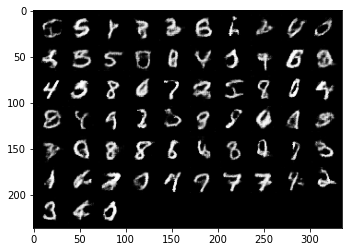

is_score 4.990436



is_score 8.003196



is_score 5.526504



is_score 5.2001944



is_score 5.1034927



is_score 5.83607



is_score 6.4354415



is_score 6.0463305



is_score 6.2935596



is_score 5.9093323



Epoch: [72] [  50/ 200] D_loss: 1.04345942, G_loss: 0.63189501
Epoch: [72] [ 100/ 200] D_loss: 1.34312892, G_loss: 0.52719200
Epoch: [72] [ 150/ 200] D_loss: 4.03114891, G_loss: 0.62537795
Epoch: [72] [ 200/ 200] D_loss: 1.45214033, G_loss: 0.67838538
Epoch: [73] [  50/ 200] D_loss: 2.05654120, G_loss: 0.58388549
Epoch: [73] [ 100/ 200] D_loss: 1.15866315, G_loss: 0.63058209
Epoch: [73] [ 150/ 200] D_loss: 1.54870629, G_loss: 0.67579842
Epoch: [73] [ 200/ 200] D_loss: 3.22277498, G_loss: 0.63150179
Epoch: [74] [  50/ 200] D_loss: 1.56364787, G_loss: 0.63626862
Epoch: [74] [ 100/ 200] D_loss: 6.30242348, G_loss: 0.60368496
Epoch: [74] [ 150/ 200] D_loss: 1.40925276, G_loss: 0.63671178
Epoch: [74] [ 200/ 200] D_loss: 7.50380135, G_loss: 0.64249897
Epoch: [75] [  50/ 200] D_los

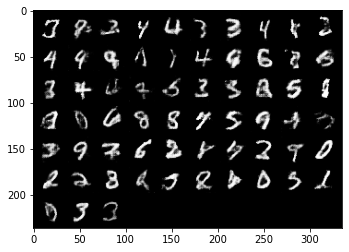

is_score 5.4348855



is_score 5.9164743



is_score 7.3468666



is_score 5.718275



is_score 5.1775923



is_score 4.3486233



is_score 6.0207233



is_score 5.1841097



is_score 5.580998



is_score 4.2957597



Epoch: [82] [  50/ 200] D_loss: 1.28675342, G_loss: 0.67009526
Epoch: [82] [ 100/ 200] D_loss: 1.89216685, G_loss: 0.69672954
Epoch: [82] [ 150/ 200] D_loss: 1.61248219, G_loss: 0.69908929
Epoch: [82] [ 200/ 200] D_loss: 3.22215676, G_loss: 0.66982186
Epoch: [83] [  50/ 200] D_loss: 1.45373845, G_loss: 0.63650775
Epoch: [83] [ 100/ 200] D_loss: 1.78569174, G_loss: 0.62556016
Epoch: [83] [ 150/ 200] D_loss: 2.50698805, G_loss: 0.69720817
Epoch: [83] [ 200/ 200] D_loss: 2.63038015, G_loss: 0.63299203
Epoch: [84] [  50/ 200] D_loss: 1.31021464, G_loss: 0.69804287
Epoch: [84] [ 100/ 200] D_loss: 1.52335835, G_loss: 0.68999535
Epoch: [84] [ 150/ 200] D_loss: 1.03607523, G_loss: 0.63512874
Epoch: [84] [ 200/ 200] D_loss: 1.18326938, G_loss: 0.67524415
Epoch: [85] [  50/ 200] D_

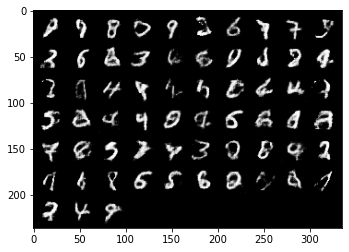

is_score 6.6621637



is_score 4.624568



is_score 4.980358



is_score 4.457155



is_score 5.0775313



is_score 5.6354985



is_score 5.099855



is_score 6.2572393



is_score 5.9477425



is_score 5.2680044



Epoch: [92] [  50/ 200] D_loss: 1.07356358, G_loss: 0.69574416
Epoch: [92] [ 100/ 200] D_loss: 1.25960398, G_loss: 0.59116668
Epoch: [92] [ 150/ 200] D_loss: 2.01964402, G_loss: 0.72308719
Epoch: [92] [ 200/ 200] D_loss: 1.37779474, G_loss: 0.71918106
Epoch: [93] [  50/ 200] D_loss: 1.34247327, G_loss: 0.72941101
Epoch: [93] [ 100/ 200] D_loss: 14.95458794, G_loss: 0.70454150
Epoch: [93] [ 150/ 200] D_loss: 1.64420211, G_loss: 0.68520194
Epoch: [93] [ 200/ 200] D_loss: 5.27821732, G_loss: 0.68814695
Epoch: [94] [  50/ 200] D_loss: 1.10153270, G_loss: 0.74749827
Epoch: [94] [ 100/ 200] D_loss: 1.90785539, G_loss: 0.67426687
Epoch: [94] [ 150/ 200] D_loss: 1.01648498, G_loss: 0.68137550
Epoch: [94] [ 200/ 200] D_loss: 1.82855487, G_loss: 0.58292913
Epoch: [95] [  50/ 200] D_l

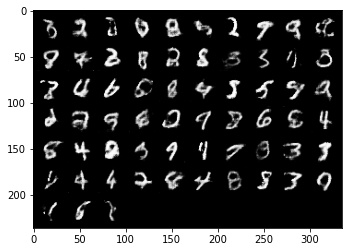

is_score 5.5806475



is_score 5.355608



is_score 5.081941



is_score 5.977716



is_score 5.6965284



is_score 7.163452



is_score 5.7486825



is_score 5.4249845



is_score 5.1575923



is_score 5.8640757



Epoch: [102] [  50/ 200] D_loss: 3.20114231, G_loss: 0.64910638
Epoch: [102] [ 100/ 200] D_loss: 2.65891266, G_loss: 0.68391299
Epoch: [102] [ 150/ 200] D_loss: 1.33599234, G_loss: 0.66469228
Epoch: [102] [ 200/ 200] D_loss: 1.88684654, G_loss: 0.74402440
Training finished!


In [29]:
params = {'beta1': 0.5, 'beta2': 0.9,'lr_g':0.002,'lr_d':0.002,'max_epochs':102}

params['z_dim'] = 10
params['base_size'] = 64

gan2 = GAN(params)


gan2.train()

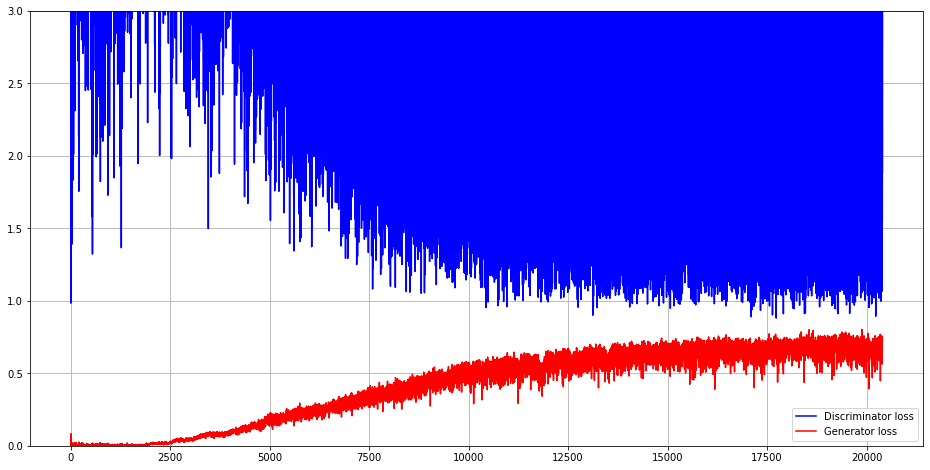

In [32]:

plt.figure(figsize=(16,8))
s=plt.plot(gan2.train_hist['D_loss'],c='b')
s=plt.plot(gan2.train_hist['G_loss'],c='r')
s = plt.ylim((0,3))
s = plt.grid()
s=plt.legend(('Discriminator loss','Generator loss'))

[5.726598, 5.79074, 5.682187, 5.890393, 5.268532, 6.2795725, 6.055489, 5.9344554, 5.502431, 5.4010115, 5.705123]


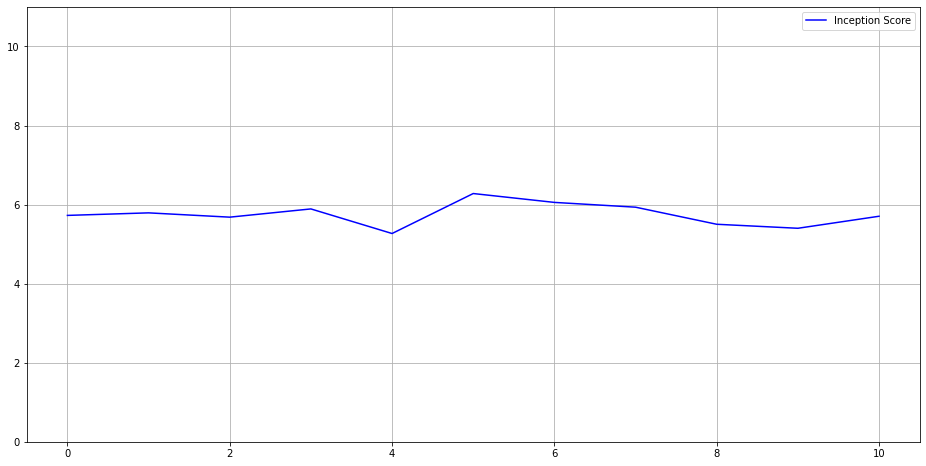

In [33]:
plt.figure(figsize=(16,8))
s=plt.plot(gan2.train_hist['IS_score'],c='b')
s = plt.ylim((0,11))
s = plt.grid()
s=plt.legend(('Inception Score','Generator loss'))
print(gan2.train_hist['IS_score'])